In [1]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [3]:
# Step 1: Load and preprocess the dataset
pkl_files = [
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_EY/EY_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_NP/NP_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_HL/HL_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_SK2/SK2_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_SK1/SK1_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_KK/KK_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_SF/SF_data.pkl",
]

# Combine data
combined_structured_data = []
for file in pkl_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        if isinstance(data["structured_data"], list):
            combined_structured_data.extend(data["structured_data"])
        elif isinstance(data["structured_data"], pd.DataFrame):
            combined_structured_data.append(data["structured_data"])

data = pd.concat(
    [entry for entry in combined_structured_data if isinstance(entry, pd.DataFrame)],
    ignore_index=True
)

# Check the total length before excluding the background
total_length_before = len(data)
print(f"Total number of rows before excluding background: {total_length_before}")

# Remove data with background label and reset index
background_label = ""  
data = data[data['ID'] != background_label].reset_index(drop=True)

# Check the total length after excluding the background
total_length_after = len(data)
print(f"Total number of rows after excluding background: {total_length_after}")


# Step 1: Normalize the DataFrame
# Normalize RGB values to [0, 1]
data['R'] /= 65535.0
data['G'] /= 65535.0
data['B'] /= 65535.0

# Normalize xr, yr, zr values to [0, 1]
data['xr'] /= data['xr'].max()
data['yr'] /= data['yr'].max()
data['zr'] /= data['zr'].max()

# Verify normalization
print("\nVerifying normalization:")
print("R range:", data['R'].min(), data['R'].max())
print("G range:", data['G'].min(), data['G'].max())
print("B range:", data['B'].min(), data['B'].max())
print("xr range:", data['xr'].min(), data['xr'].max())
print("yr range:", data['yr'].min(), data['yr'].max())
print("zr range:", data['zr'].min(), data['zr'].max())

# Step 2: Calculate grayscale and add it to the DataFrame
def calculate_grayscale(row):
    return 0.299 * row['R'] + 0.587 * row['G'] + 0.114 * row['B']

data['grayscale'] = data.apply(calculate_grayscale, axis=1)

# Step 3: Prepare slices, auxiliary features, and targets
# Prepare slices, auxiliary features, and targets
grid_size = 128
slices = np.zeros((len(data), grid_size, grid_size, 2), dtype=np.float32)  # Channels: weight, grayscale
auxiliary_features = np.zeros((len(data), 1), dtype=np.float32)  # zr
targets = data[['R', 'G', 'B']].values.astype(np.float32)  # Convert to float32 for PyTorch

for idx, row in data.iterrows():
    # Map xr and yr to grid indices
    x_idx = min(int(row['xr'] * (grid_size - 1)), grid_size - 1)  # Clamp to grid_size - 1
    y_idx = min(int(row['yr'] * (grid_size - 1)), grid_size - 1)  # Clamp to grid_size - 1

    # Populate slices and auxiliary_features
    slices[idx, x_idx, y_idx, 0] = row['weight']     # Map weight
    slices[idx, x_idx, y_idx, 1] = row['grayscale']  # Map grayscale value
    auxiliary_features[idx, 0] = row['zr']          # Store zr as auxiliary feature

# Transpose slices to (N, C, H, W)
slices = slices.transpose(0, 3, 1, 2)  # From (N, H, W, C) to (N, C, H, W)

# Normalize slices
print("\nNormalizing slices:")
slices[..., 0] /= slices[..., 0].max()  # Normalize weight channel to [0, 1]
slices[..., 1] /= slices[..., 1].max()  # Normalize grayscale channel to [0, 1]

# Verify normalization for slices and targets
print("\nVerifying slices and targets normalization:")
print("Slices - Weight channel range after normalization:", slices[..., 0].min(), slices[..., 0].max())
print("Slices - Grayscale channel range after normalization:", slices[..., 1].min(), slices[..., 1].max())
print("RGB Targets - R range:", targets[:, 0].min(), targets[:, 0].max())
print("RGB Targets - G range:", targets[:, 1].min(), targets[:, 1].max())
print("RGB Targets - B range:", targets[:, 2].min(), targets[:, 2].max())

# Step 4: Split into training and testing sets
X_train_slices, X_test_slices, X_train_aux, X_test_aux, y_train, y_test = train_test_split(
    slices, auxiliary_features, targets, test_size=0.3, random_state=42
)

# Verify shapes
print(f"Training slices shape: {X_train_slices.shape}")
print(f"Testing slices shape: {X_test_slices.shape}")
print(f"Auxiliary features shape: {X_train_aux.shape}")
print(f"Targets shape: {y_train.shape}")


Total number of rows before excluding background: 15572
Total number of rows after excluding background: 11511

Verifying normalization:
R range: 0.0 1.0
G range: 0.0 1.0
B range: 0.0 1.0
xr range: 0.0009350452141113296 1.0
yr range: 0.0 1.0
zr range: 0.0 1.0

Normalizing slices:

Verifying slices and targets normalization:
Slices - Weight channel range after normalization: 0.0 1.0
Slices - Grayscale channel range after normalization: 0.0 1.0
RGB Targets - R range: 0.0 1.0
RGB Targets - G range: 0.0 1.0
RGB Targets - B range: 0.0 1.0
Training slices shape: (8057, 2, 128, 128)
Testing slices shape: (3454, 2, 128, 128)
Auxiliary features shape: (8057, 1)
Targets shape: (8057, 3)


In [4]:
# Step 1: Encode 'ID' to class labels
label_encoder = LabelEncoder()
data['class_label'] = label_encoder.fit_transform(data['ID'])

# Step 2: Preserve original indices and split data
original_indices = data.index.to_numpy()  # Keep original indices
X_train_indices, X_test_indices = train_test_split(
    original_indices, test_size=0.3, random_state=42
)

# Map slices, auxiliary features, and targets using indices
X_train_slices = slices[X_train_indices]
X_test_slices = slices[X_test_indices]
X_train_aux = auxiliary_features[X_train_indices]
X_test_aux = auxiliary_features[X_test_indices]
y_train = targets[X_train_indices]
y_test = targets[X_test_indices]

# Map class labels for SMOTE using train indices
y_train_classes = data.loc[X_train_indices, 'class_label'].values

# Count the number of samples per class
class_counts = Counter(y_train_classes)

# Filter out classes with only one sample
sufficient_classes = [cls for cls, count in class_counts.items() if count > 1]
filtered_indices = [i for i, cls in enumerate(y_train_classes) if cls in sufficient_classes]

# Combine flattened slices and auxiliary features
X_train_combined = np.hstack([
    X_train_slices.reshape(X_train_slices.shape[0], -1),  # Flatten slices
    X_train_aux  # Include auxiliary features
])

# Filter X_train_combined and y_train_classes
X_train_combined_filtered = X_train_combined[filtered_indices]
y_train_classes_filtered = y_train_classes[filtered_indices]

# Step 4: Apply SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_train_smote, y_train_classes_smote = smote.fit_resample(X_train_combined_filtered, y_train_classes_filtered)

# Step 5: Reshape SMOTE outputs
X_train_slices_smote = X_train_smote[:, :-1].reshape(-1, 2, 128, 128)  # Slices
X_train_aux_smote = X_train_smote[:, -1].reshape(-1, 1)  # Auxiliary features
y_train_IDs_smote = label_encoder.inverse_transform(y_train_classes_smote)

# Step 6: Map RGB targets for oversampled IDs
y_train_smote = np.array([
    data.loc[data['ID'] == ID, ['R', 'G', 'B']].iloc[0].values for ID in y_train_IDs_smote
])

# Verify shapes
print(f"New training slices shape after SMOTE: {X_train_slices_smote.shape}")
print(f"New auxiliary features shape after SMOTE: {X_train_aux_smote.shape}")
print(f"New targets shape after SMOTE: {y_train_smote.shape}")


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

New training slices shape after SMOTE: (18270, 2, 128, 128)
New auxiliary features shape after SMOTE: (18270, 1)
New targets shape after SMOTE: (18270, 3)


SMOTE is designed for classification problems, where the target y_train contains discrete class labels, not continuous values. Your problem seems to involve continuous RGB values as targets, indicating a regression task. SMOTE is not directly applicable for regression tasks.

Alternative Solution
If you still want to balance the data, here are some approaches:

1. Cluster-Based SMOTE for Regression
Discretize the target values (e.g., cluster them into bins) to create pseudo-classes.
Apply SMOTE on these pseudo-classes to oversample.
Map the oversampled data back to their original continuous target values.

In [7]:
# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, slices, auxiliary, targets):
        self.slices = slices
        self.auxiliary = auxiliary
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        slice_tensor = torch.tensor(self.slices[idx], dtype=torch.float32)  # [C, H, W]
        aux_tensor = torch.tensor(self.auxiliary[idx], dtype=torch.float32)  # [1]
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)  # [3]
        return slice_tensor, aux_tensor, target_tensor


# Create PyTorch DataLoaders
batch_size = 64

# Step 5: Create PyTorch DataLoaders
train_dataset = CustomDataset(X_train_slices_smote, X_train_aux_smote, y_train_smote)
test_dataset = CustomDataset(X_test_slices, X_test_aux, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
class ResNetWithAuxiliaryFeatures(nn.Module):
    def __init__(self):
        super(ResNetWithAuxiliaryFeatures, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.avgpool = nn.Identity()  # Remove global average pooling
        self.resnet.fc = nn.Identity()       # Remove the fully connected layer

        # Auxiliary branch
        self.fc_aux = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        # Combine features and predict RGB values
        self.combined_conv = nn.Sequential(
            nn.Conv2d(512 + 64, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(256, 3, kernel_size=1),  # Predict 3 channels (R, G, B)
        )

    def forward(self, slices, aux):
        # Process image slices with ResNet
        resnet_features = self.resnet(slices)  # [B, 512, H/32, W/32] (spatial)

        #print(f"ResNet output shape after avgpool removal: {resnet_features.shape}")
        # Handle flattened output by reshaping if needed
        if len(resnet_features.shape) == 2:  # If [B, 8192], reshape to [B, 512, H/32, W/32]
            spatial_dim = int((resnet_features.size(1) // 512) ** 0.5)
            resnet_features = resnet_features.view(-1, 512, spatial_dim, spatial_dim)

        # Upsample to match input dimensions
        resnet_features_upsampled = nn.functional.interpolate(
            resnet_features, size=(slices.size(2), slices.size(3)), mode='bilinear', align_corners=False
        )

        # Process auxiliary features
        aux_flat = aux.view(aux.size(0), -1)
        aux_features = self.fc_aux(aux_flat).unsqueeze(2).unsqueeze(3)
        aux_features_expanded = aux_features.expand(-1, -1, slices.size(2), slices.size(3))

        # Combine ResNet and auxiliary features
        combined_features = torch.cat((resnet_features_upsampled, aux_features_expanded), dim=1)

        # Predict RGB values
        return self.combined_conv(combined_features)  # [B, 3, H, W]


In [9]:
# Paths for saving outputs
output_dir = "/scratch/ne2213/projects/CV-Project/NWBelegans/Final_ResNetModel_NoBG_SMOTE"
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "best_model.pth")
log_path = os.path.join(output_dir, "training_logs.pkl")  # Changed extension to .pkl

# Initialize variables to track the best model
best_val_loss = float("inf")
training_logs = {"epoch": [], "train_loss": [], "val_loss": []}

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetWithAuxiliaryFeatures().to(device)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()  # Mean squared error for regression
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 100
early_stopping_patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for slices, aux, targets in train_loader:
        # Move inputs and targets to the same device as the model
        slices, aux, targets = slices.to(device), aux.to(device), targets.to(device)
        
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(slices, aux)  # [B, 3, H, W]
        outputs_flat = outputs.mean(dim=(2, 3))  # Average over spatial dimensions [B, 3]
    
        # Compute loss
        loss = criterion(outputs_flat, targets)  # Regression loss
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()


    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for slices, aux, targets in test_loader:
            slices, aux, targets = slices.to(device), aux.to(device), targets.to(device)
            outputs = model(slices, aux)
            # print("Outputs:", outputs.mean(dim=(2, 3)).detach().cpu().numpy())
            # print("Targets:", targets.detach().cpu().numpy())
            outputs_flat = outputs.mean(dim=(2, 3))
            loss = criterion(outputs_flat, targets)
            val_loss += loss.item()

    val_loss /= len(test_loader)

    # Save metrics
    training_logs["epoch"].append(epoch + 1)
    training_logs["train_loss"].append(train_loss)
    training_logs["val_loss"].append(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print(f"Epoch {epoch + 1}: Best model saved with validation loss: {val_loss:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Step scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Save training logs to a .pkl file
with open(log_path, "wb") as f:
    pickle.dump(training_logs, f)


Epoch 1: Best model saved with validation loss: 0.0698
Epoch 1/100, Train Loss: 0.0083, Val Loss: 0.0698
Epoch 2/100, Train Loss: 0.0014, Val Loss: 0.0718
Epoch 3/100, Train Loss: 0.0018, Val Loss: 0.0792
Epoch 4/100, Train Loss: 0.0017, Val Loss: 0.0736
Epoch 5: Best model saved with validation loss: 0.0671
Epoch 5/100, Train Loss: 0.0013, Val Loss: 0.0671
Epoch 6/100, Train Loss: 0.0012, Val Loss: 0.0697
Epoch 7/100, Train Loss: 0.0013, Val Loss: 0.0703
Epoch 8/100, Train Loss: 0.0011, Val Loss: 0.0702
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/100, Train Loss: 0.0013, Val Loss: 0.0724
Epoch 10/100, Train Loss: 0.0009, Val Loss: 0.0708
Epoch 11/100, Train Loss: 0.0006, Val Loss: 0.0702
Epoch 12/100, Train Loss: 0.0006, Val Loss: 0.0704
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Epoch 13/100, Train Loss: 0.0006, Val Loss: 0.0708
Epoch 14/100, Train Loss: 0.0005, Val Loss: 0.0701
Early stopping at epoch 15


In [ ]:
# Evaluate

In [10]:
# Load the best model
model = ResNetWithAuxiliaryFeatures().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


ResNetWithAuxiliaryFeatures(
  (resnet): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize lists to store predictions and ground truths
predictions = []
ground_truths = []

with torch.no_grad():  # No gradient calculation during evaluation
    for slices, aux, targets in test_loader:
        slices, aux, targets = slices.to(device), aux.to(device), targets.to(device)
        outputs = model(slices, aux)  # [B, 3, H, W]
        outputs_flat = outputs.mean(dim=(2, 3))  # Average over spatial dimensions

        predictions.append(outputs_flat.cpu().numpy())
        ground_truths.append(targets.cpu().numpy())

# Convert to numpy arrays
predictions = np.vstack(predictions)
ground_truths = np.vstack(ground_truths)


In [12]:
# Calculate regression metrics
mse = mean_squared_error(ground_truths, predictions)
mae = mean_absolute_error(ground_truths, predictions)
r2 = r2_score(ground_truths, predictions)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2: {r2:.4f}")


Test MSE: 0.0671
Test MAE: 0.1070
Test R^2: -0.0709


In [13]:
def calculate_accuracy(predictions, ground_truths, threshold=0.05):
    # Calculate the absolute error for each RGB component
    errors = np.abs(predictions - ground_truths)
    
    # Check if all components (R, G, B) are within the threshold
    within_threshold = (errors <= threshold).all(axis=1)
    
    # Calculate accuracy as the percentage of samples within the threshold
    accuracy = np.mean(within_threshold) * 100  # Convert to percentage
    return accuracy
    
# Calculate accuracy with a chosen threshold
accuracy = calculate_accuracy(predictions, ground_truths, threshold=0.05)
print(f"Test Accuracy: {accuracy:.2f}% (within ±0.05 tolerance)")


Test Accuracy: 66.33% (within ±0.05 tolerance)


In [14]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Ensure data is normalized to [0, 1]
predictions = np.clip(predictions, 0, 1)
ground_truths = np.clip(ground_truths, 0, 1)

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(predictions, ground_truths):
    mse_values = np.mean((predictions - ground_truths) ** 2, axis=1)  # Per sample MSE
    average_mse = np.mean(mse_values)  # Overall MSE
    return average_mse

# Function to calculate Structural Similarity Index (SSIM)
def calculate_ssim(predictions, ground_truths):
    # Calculate SSIM per channel
    ssim_r = ssim(predictions[:, 0], ground_truths[:, 0], data_range=1.0)
    ssim_g = ssim(predictions[:, 1], ground_truths[:, 1], data_range=1.0)
    ssim_b = ssim(predictions[:, 2], ground_truths[:, 2], data_range=1.0)
    # Average SSIM across channels
    average_ssim = (ssim_r + ssim_g + ssim_b) / 3
    return average_ssim

# Function to calculate the Colorfulness Metric
def calculate_average_colorfulness(predictions):
    rg = predictions[:, 0] - predictions[:, 1]  # Difference between R and G channels
    yb = 0.5 * (predictions[:, 0] + predictions[:, 1]) - predictions[:, 2]  # Difference between Y and B

    std_rg = np.std(rg)  # Standard deviation of RG differences
    std_yb = np.std(yb)  # Standard deviation of YB differences
    mean_rg = np.mean(rg)  # Mean of RG differences
    mean_yb = np.mean(yb)  # Mean of YB differences

    # Calculate colorfulness metric
    colorfulness = np.sqrt(std_rg ** 2 + std_yb ** 2) + 0.3 * np.sqrt(mean_rg ** 2 + mean_yb ** 2)
    return colorfulness

# Calculate Metrics
mse = calculate_mse(predictions, ground_truths)
print(f"Mean Squared Error (MSE): {mse:.4f}")

ssim_score = calculate_ssim(predictions, ground_truths)
print(f"Structural Similarity Index (SSIM): {ssim_score:.4f}")

colorfulness = calculate_average_colorfulness(predictions)
print(f"Colorfulness Metric: {colorfulness:.4f}")


Mean Squared Error (MSE): 0.0669
Structural Similarity Index (SSIM): 0.2038
Colorfulness Metric: 0.0473


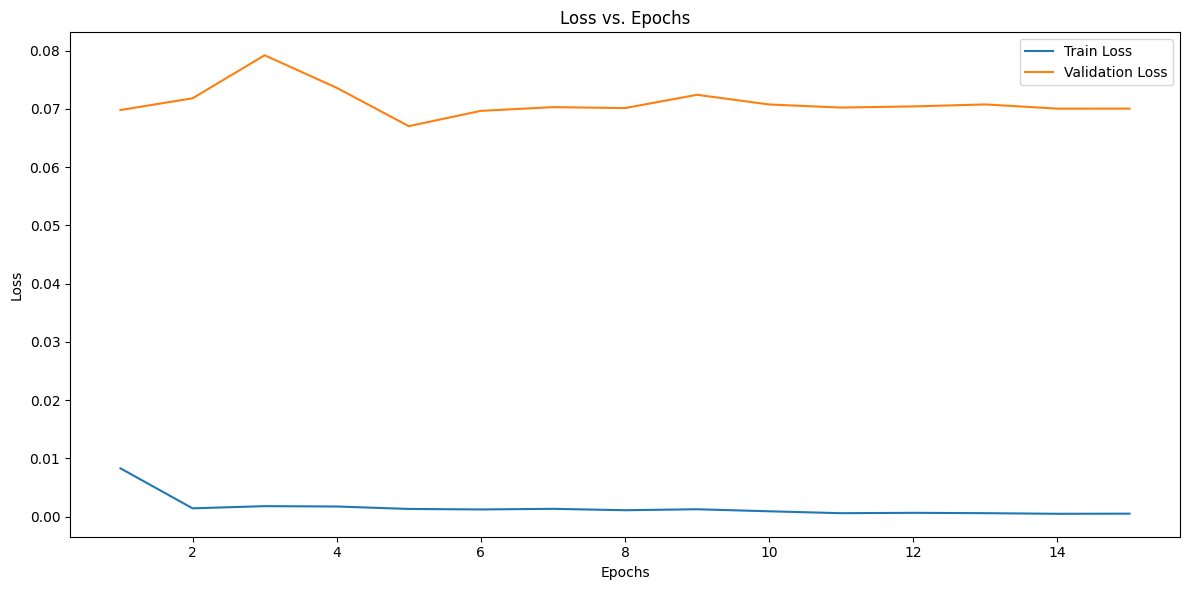

In [18]:
import matplotlib.pyplot as plt

# Plot loss and accuracy trends
def plot_metrics(training_logs):
    epochs = training_logs["epoch"]
    train_loss = training_logs["train_loss"]
    val_loss = training_logs["val_loss"]

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid()

    plt.grid()

    plt.tight_layout()
    plt.show()

# Load saved training logs
log_path = "/scratch/ne2213/projects/CV-Project/NWBelegans/Final_ResNetModel_NoBG_SMOTE/training_logs.pkl"
with open(log_path, "rb") as f:
    training_logs = pickle.load(f)

# Call the function to visualize metrics
plot_metrics(training_logs)

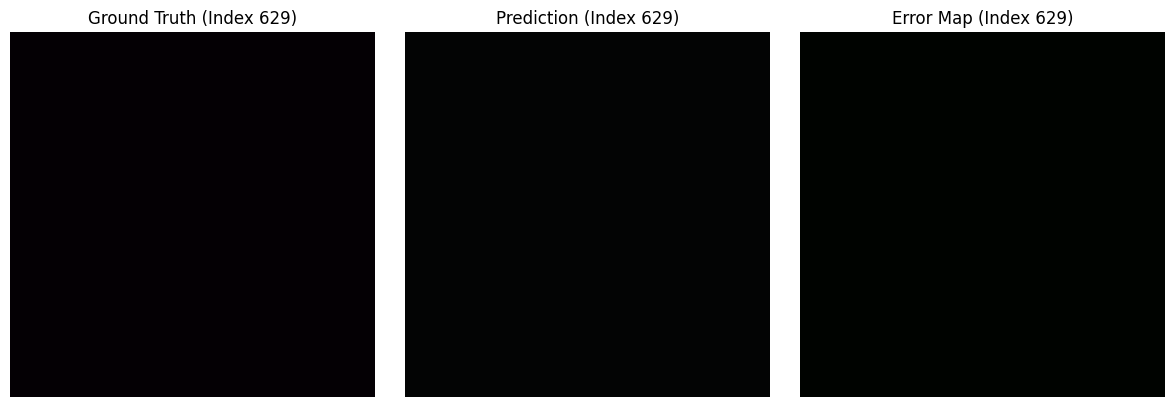

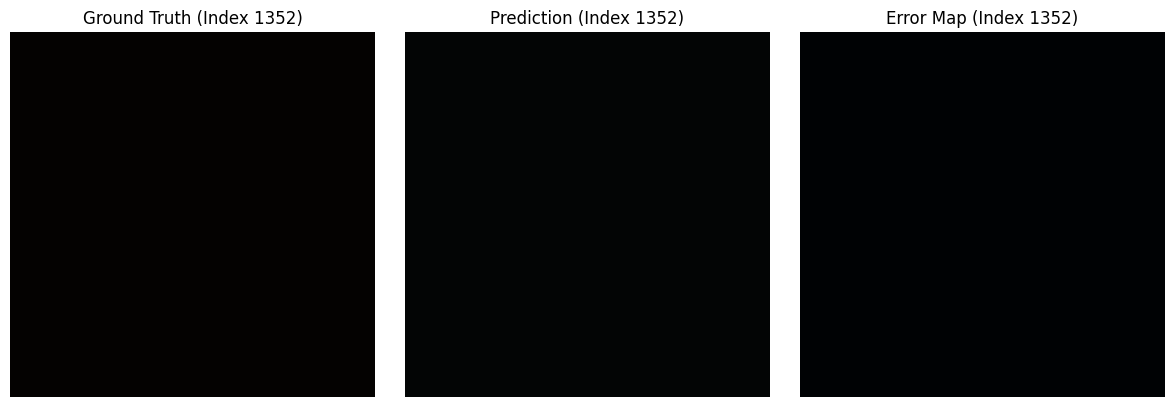

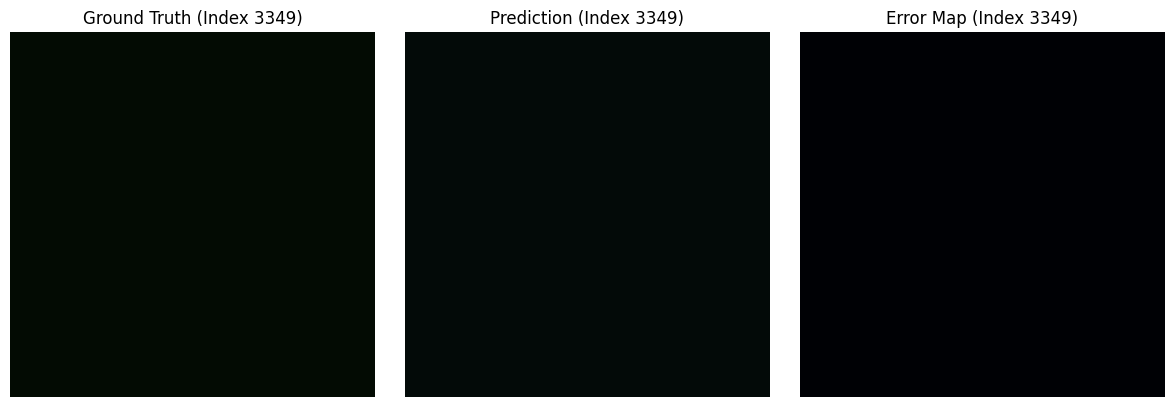

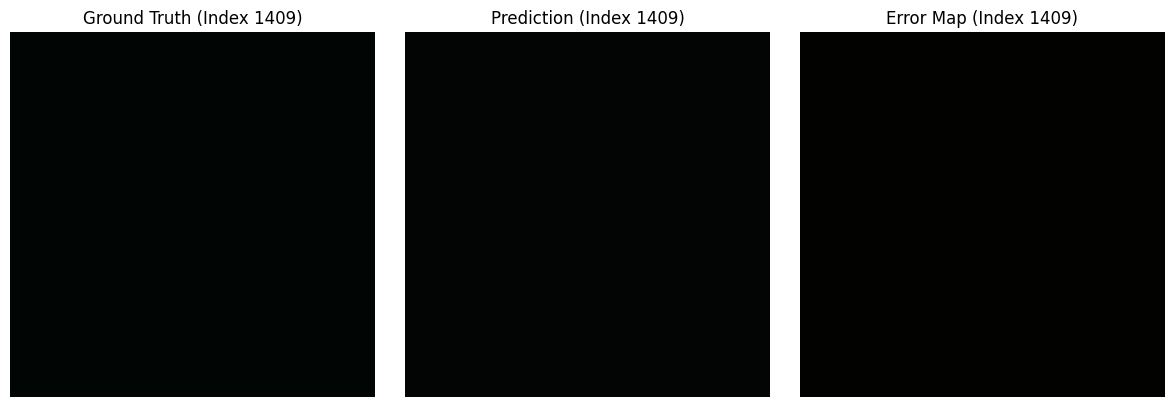

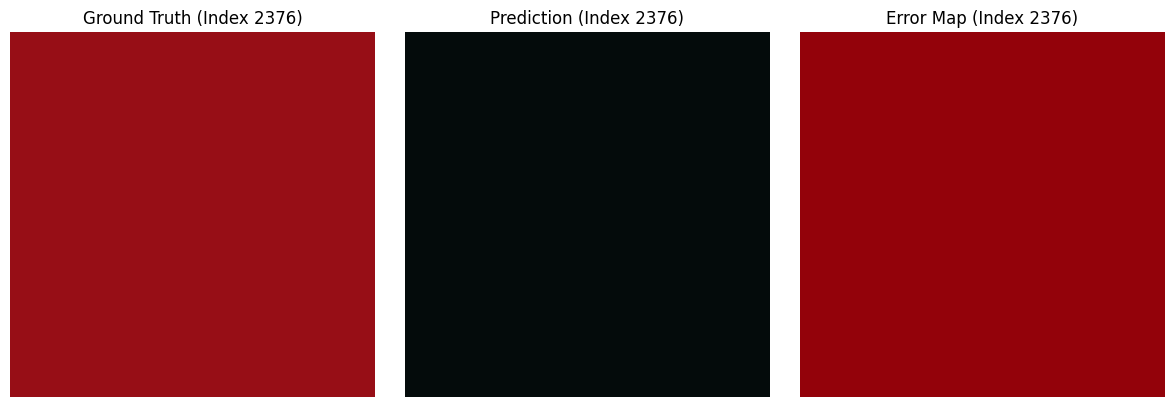

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(predictions, ground_truths, indices=None, num_samples=5):
    """
    Visualize ground truth and predicted RGB values along with the error map.

    Parameters:
    - predictions: Predicted RGB values as a NumPy array of shape [N, 3].
    - ground_truths: Ground truth RGB values as a NumPy array of shape [N, 3].
    - indices: Indices of the data to visualize. If None, random indices are chosen.
    - num_samples: Number of samples to visualize.
    """
    # If indices are not provided, choose random samples
    if indices is None:
        indices = np.random.choice(len(predictions), size=num_samples, replace=False)
    
    for idx in indices:
        pred_rgb = predictions[idx].reshape(1, 1, 3)  # Reshape for visualization
        gt_rgb = ground_truths[idx].reshape(1, 1, 3)  # Reshape for visualization
        
        # Compute the error map
        error_map = np.abs(pred_rgb - gt_rgb)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        # Ground truth RGB
        axes[0].imshow(gt_rgb, extent=[0, 1, 0, 1], origin='lower')
        axes[0].set_title(f"Ground Truth (Index {idx})")
        axes[0].axis("off")
        
        # Predicted RGB
        axes[1].imshow(pred_rgb, extent=[0, 1, 0, 1], origin='lower')
        axes[1].set_title(f"Prediction (Index {idx})")
        axes[1].axis("off")
        
        # Error map
        axes[2].imshow(error_map, extent=[0, 1, 0, 1], origin='lower', cmap="inferno")
        axes[2].set_title(f"Error Map (Index {idx})")
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()

# Example usage:
# Visualize 5 random samples from the test set
visualize_predictions(predictions, ground_truths, num_samples=5)


Visualizing slice for z=0.4074074074074074


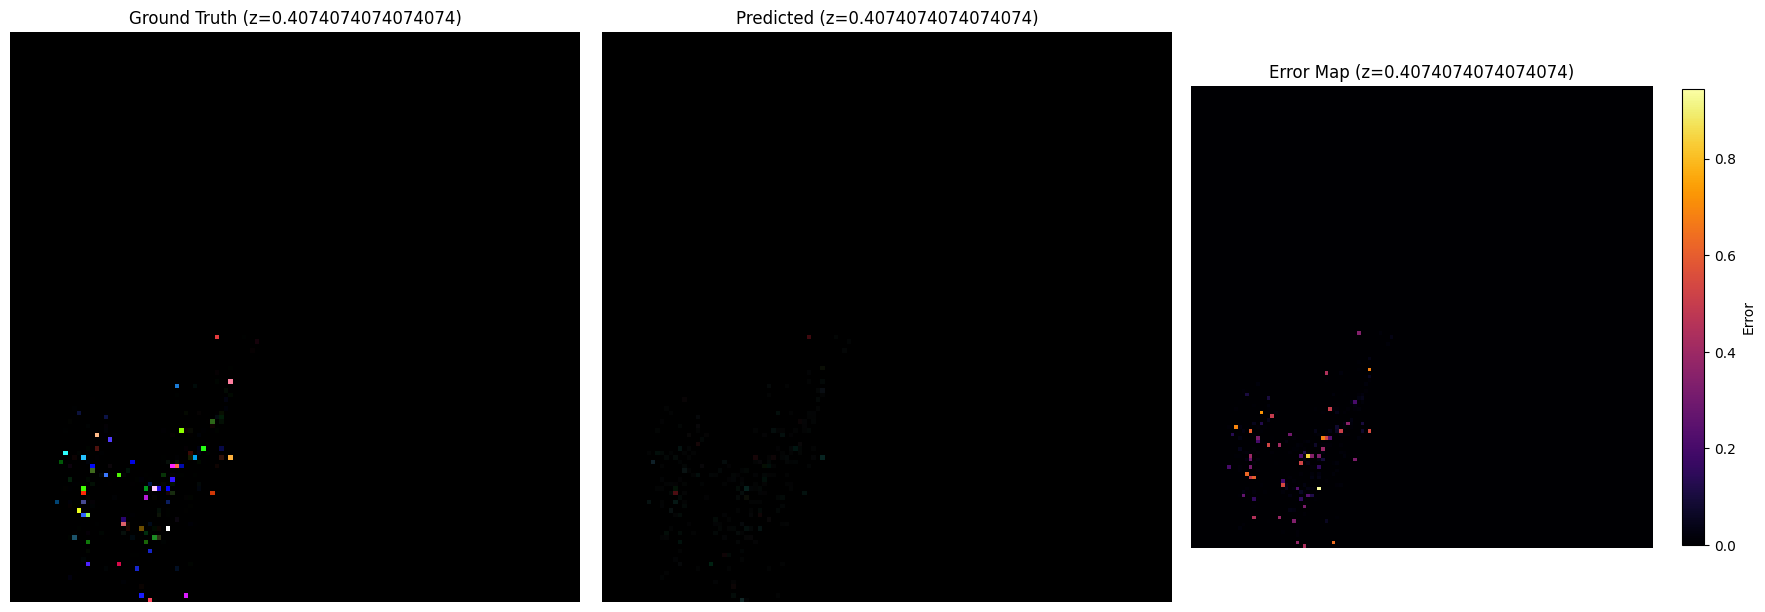

Visualizing slice for z=0.14814814814814814


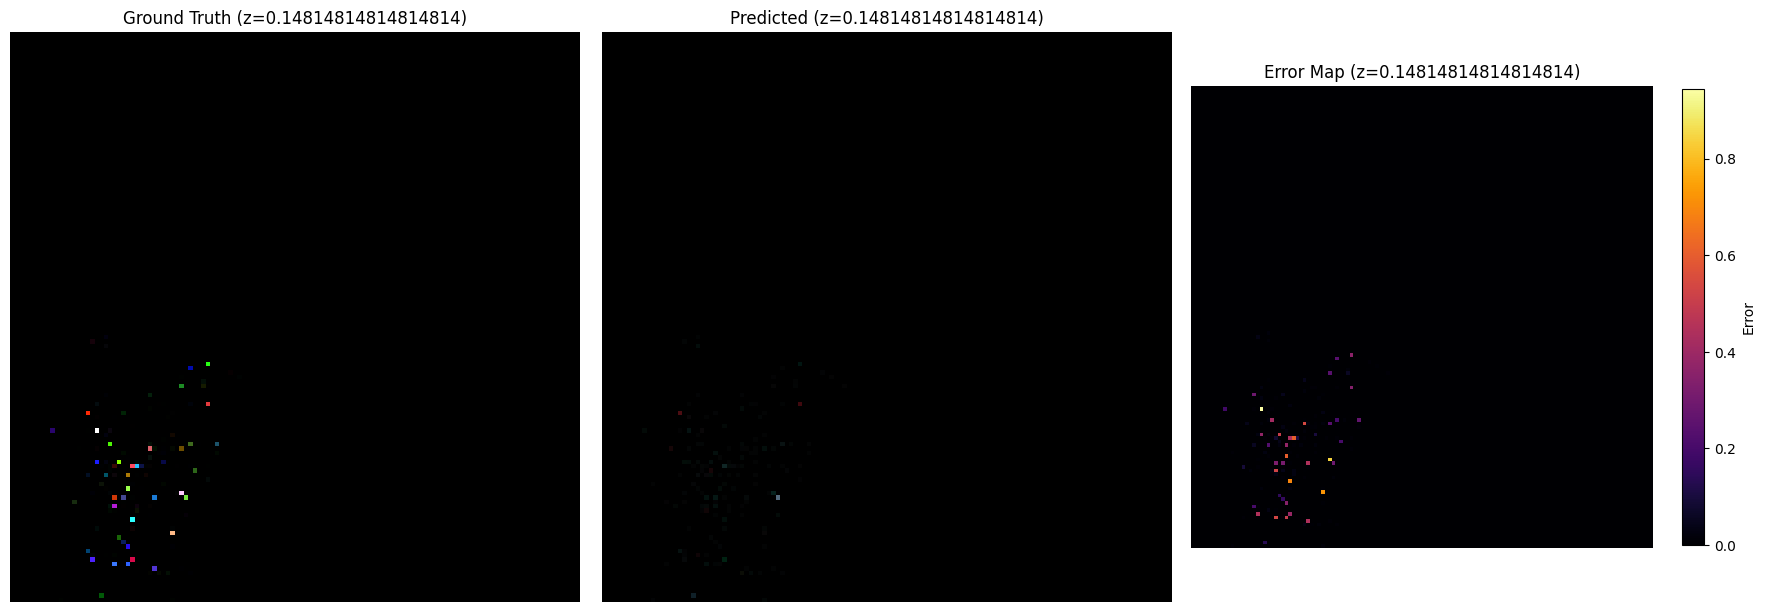

Visualizing slice for z=0.1111111111111111


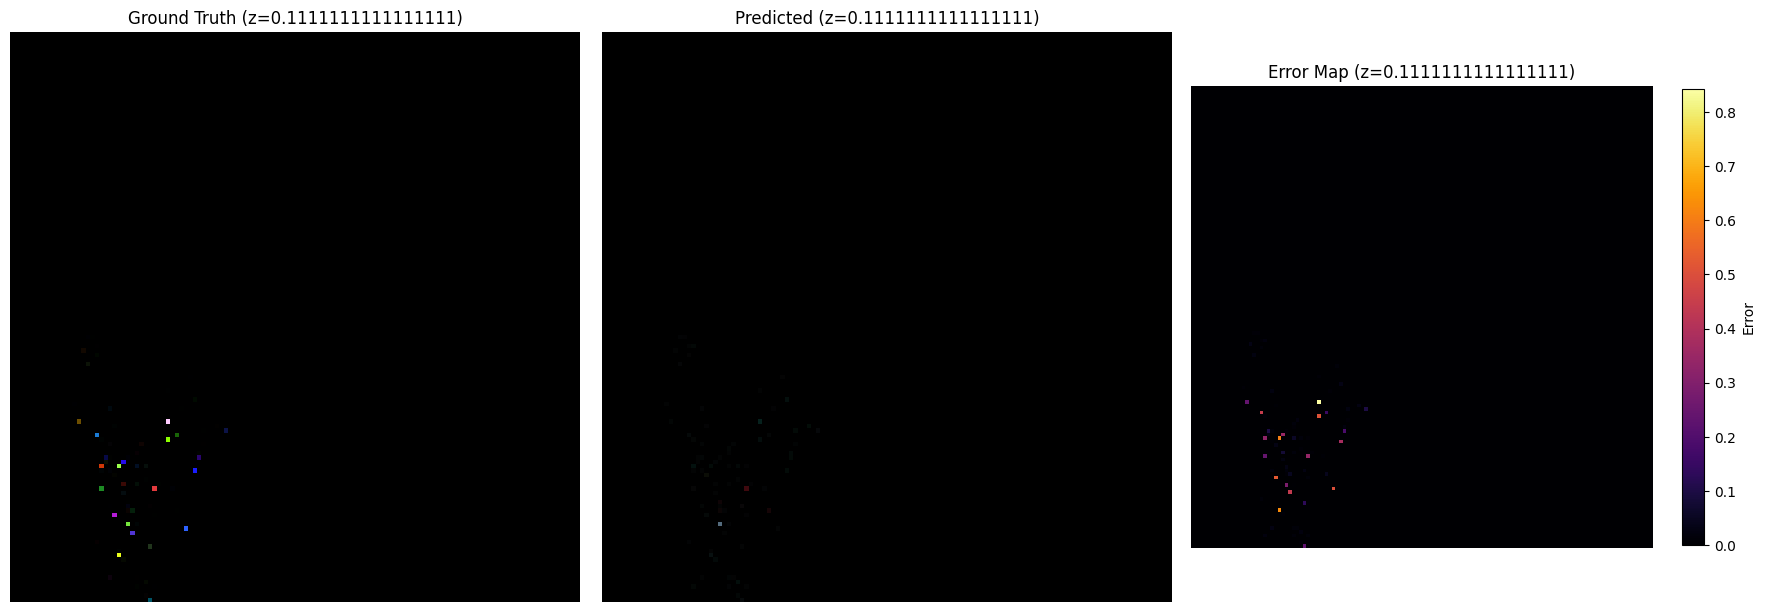

Visualizing slice for z=0.48148148148148145


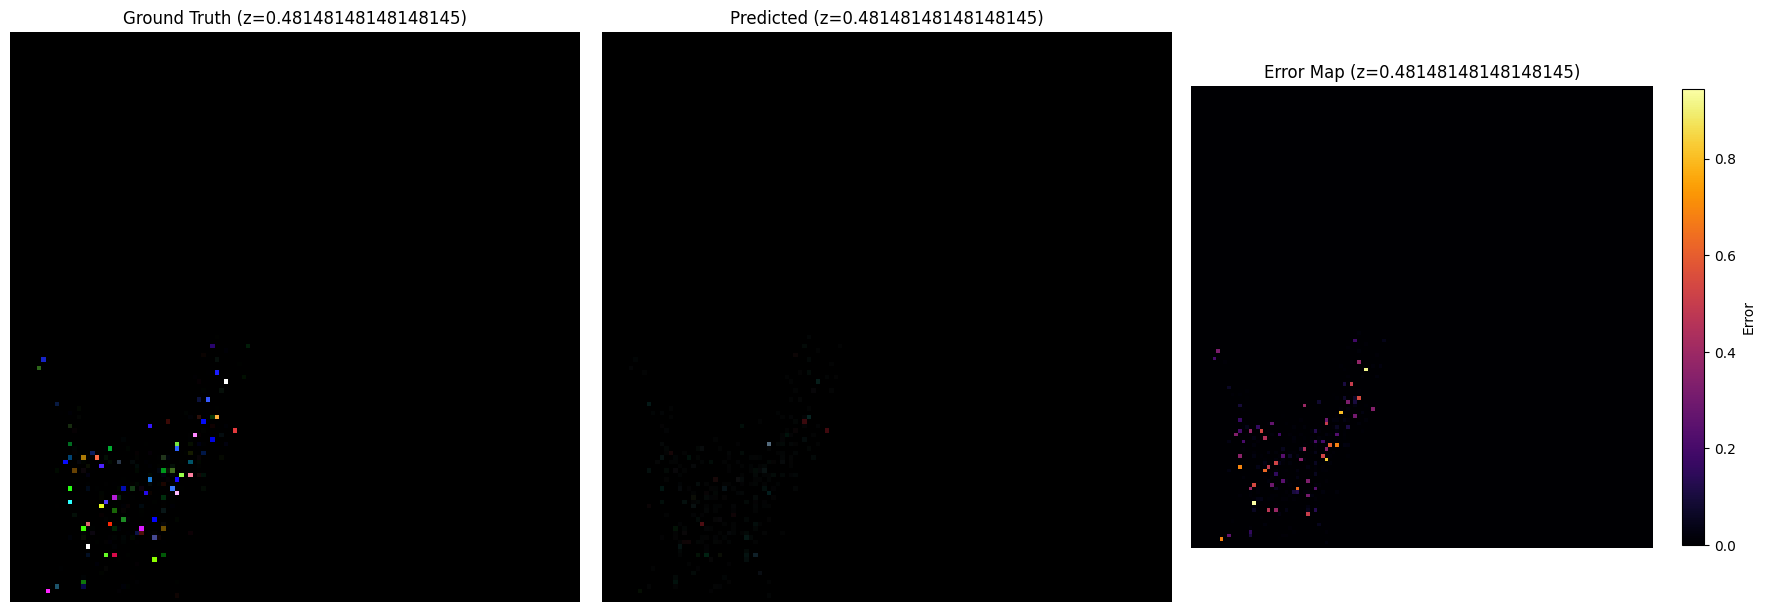

Visualizing slice for z=0.18518518518518517


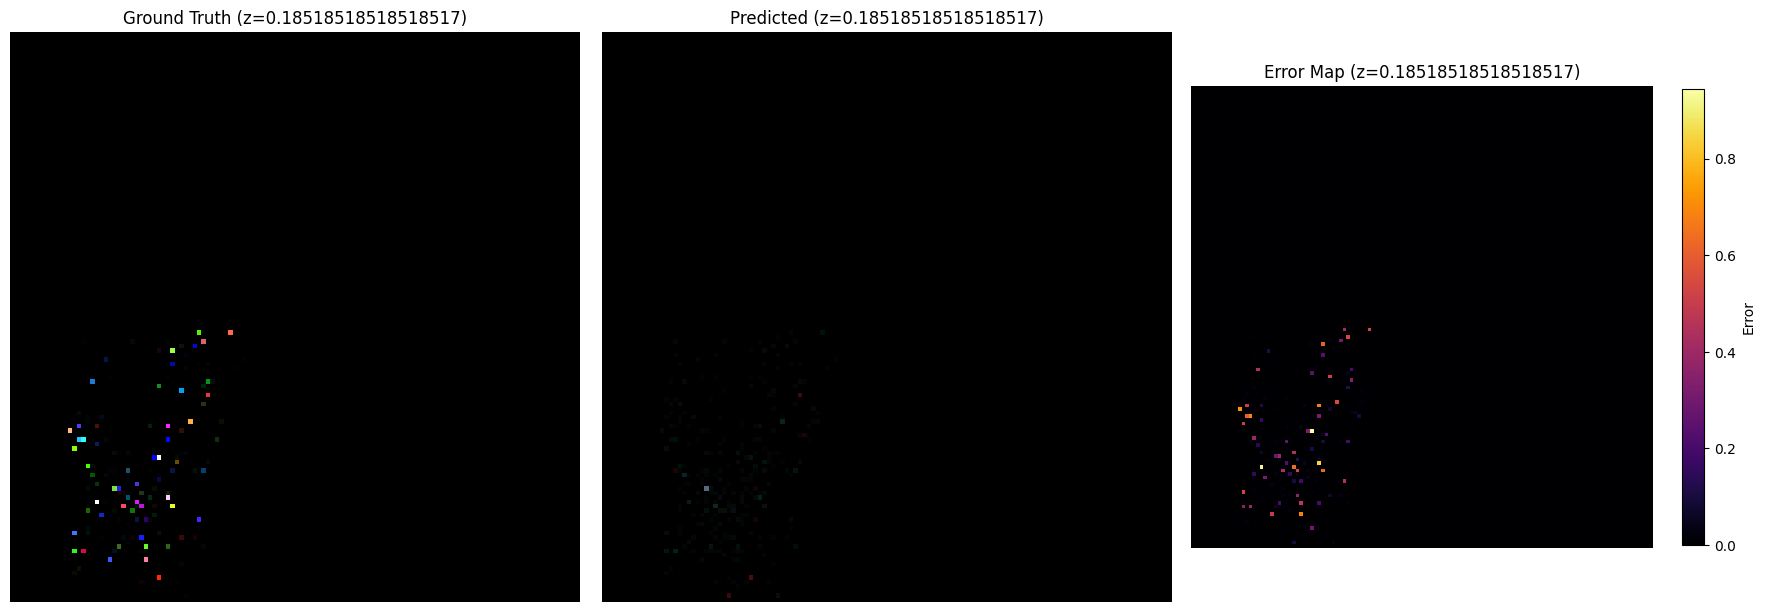

Visualizing slice for z=0.0


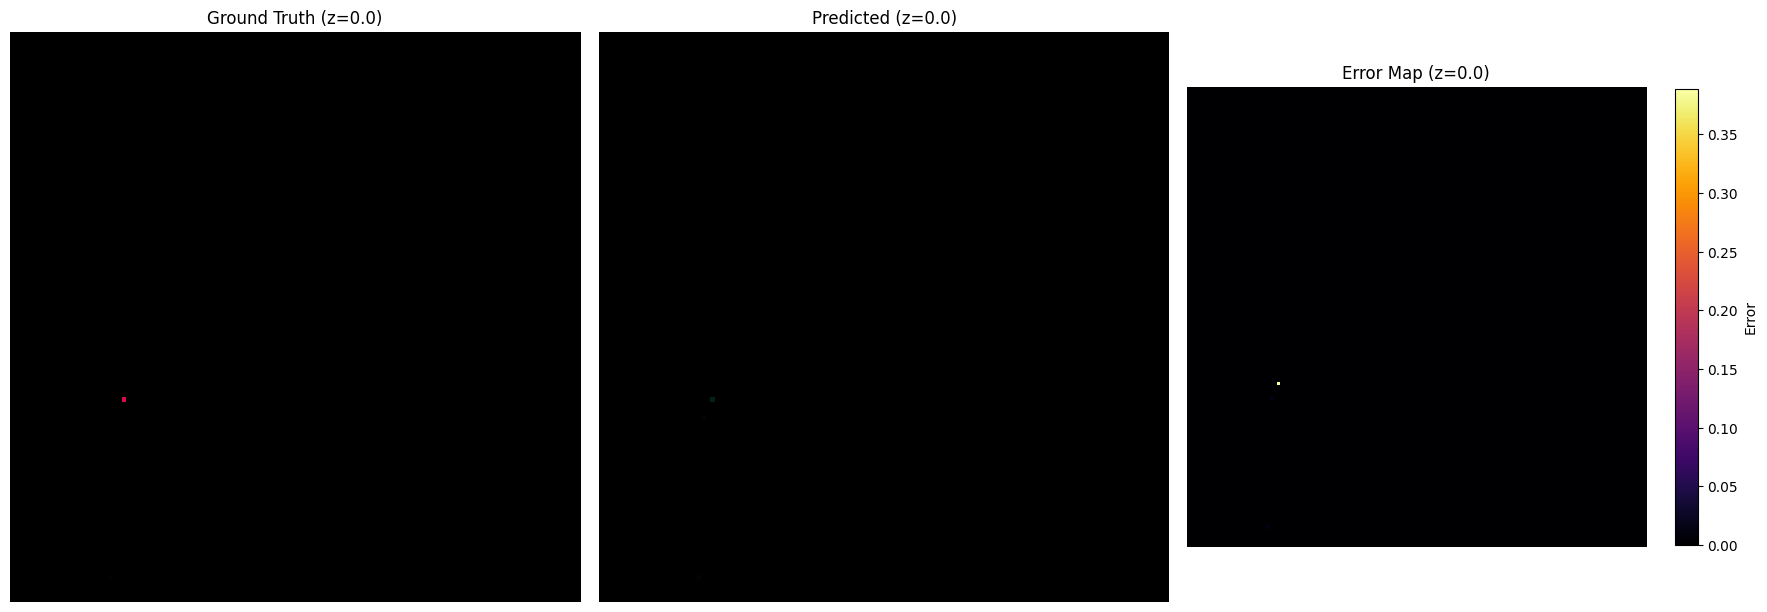

Visualizing slice for z=0.25925925925925924


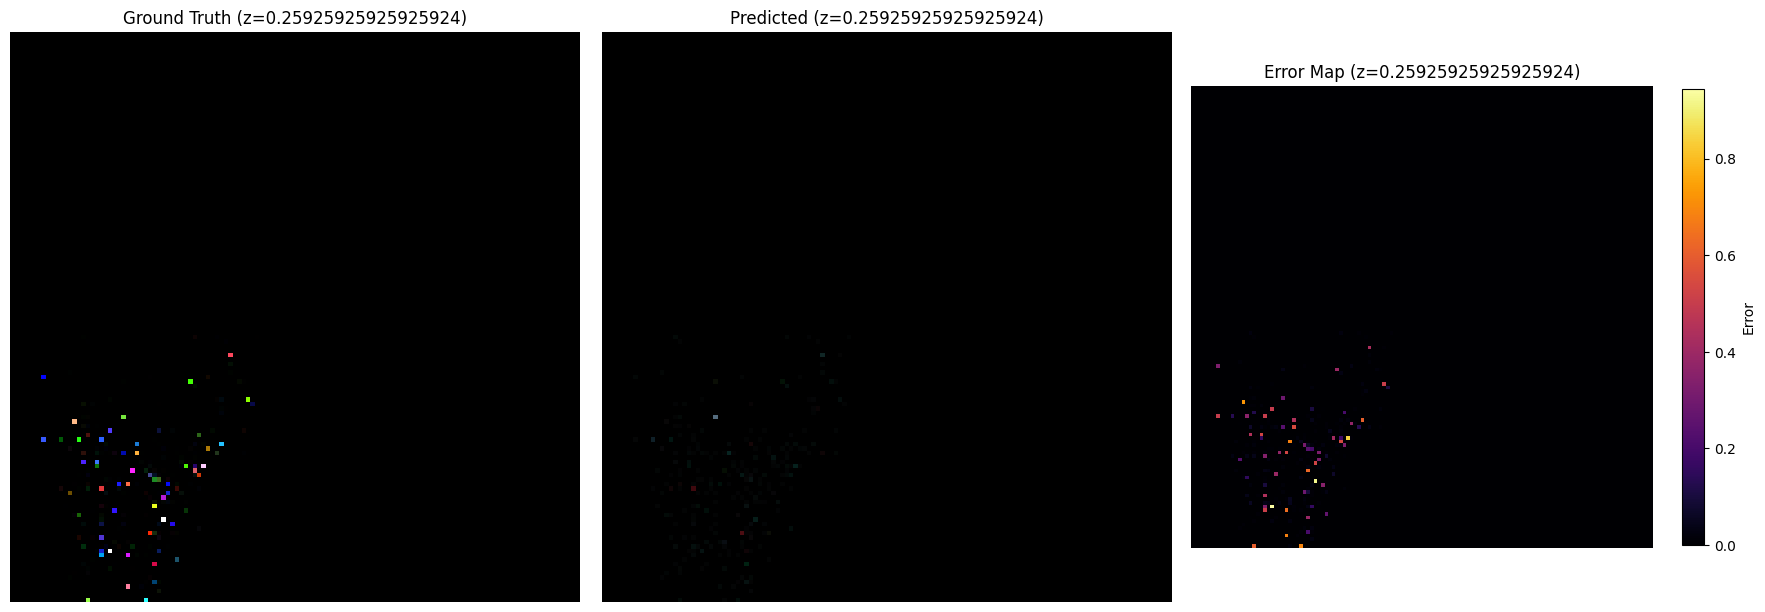

Visualizing slice for z=0.4444444444444444


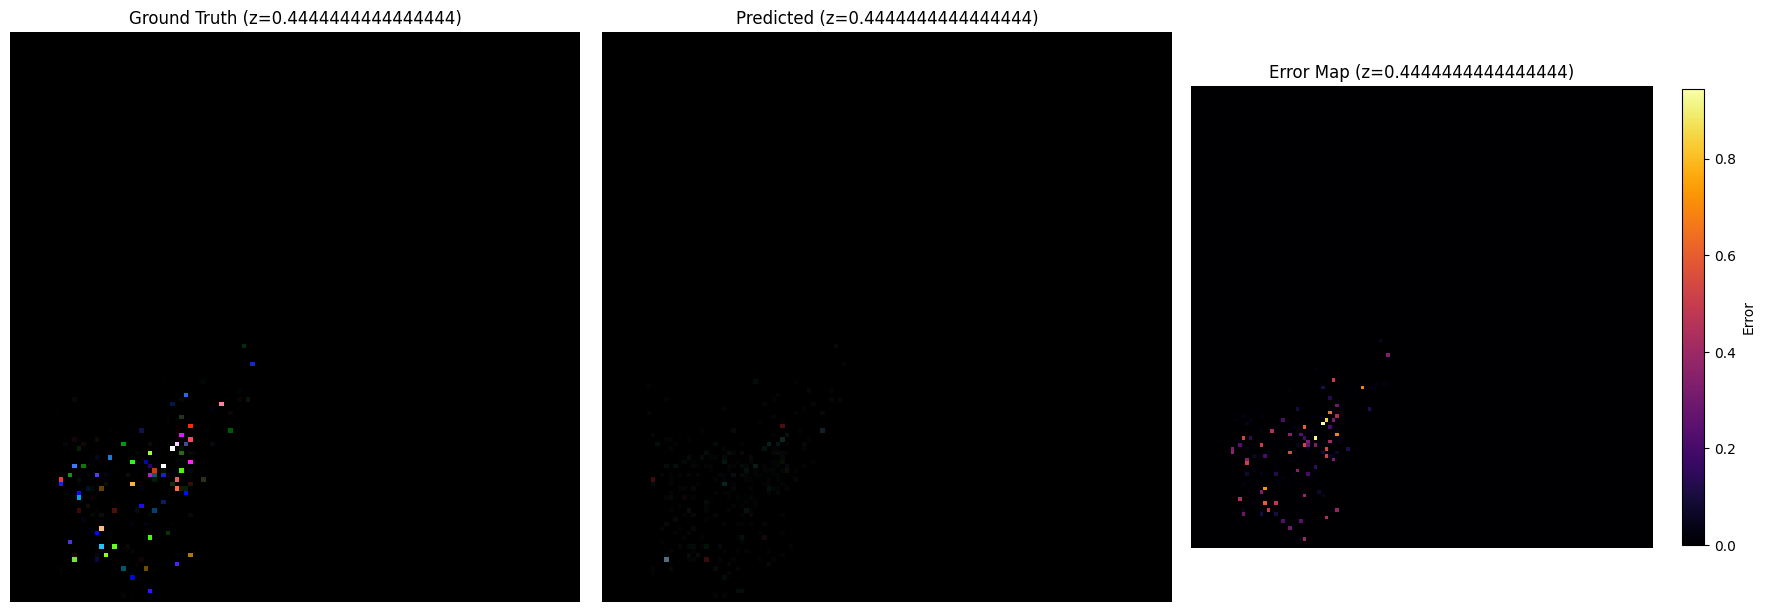

Visualizing slice for z=0.5185185185185185


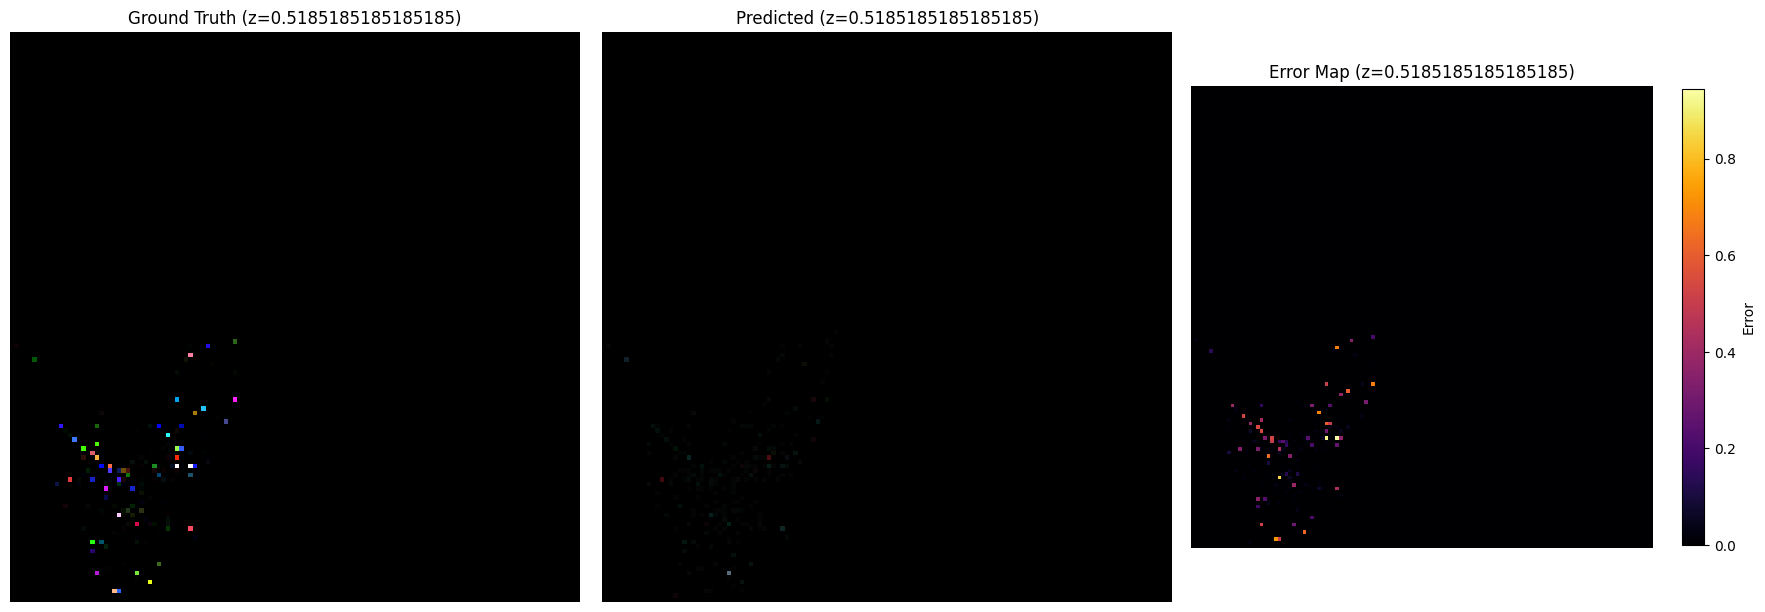

Visualizing slice for z=0.037037037037037035


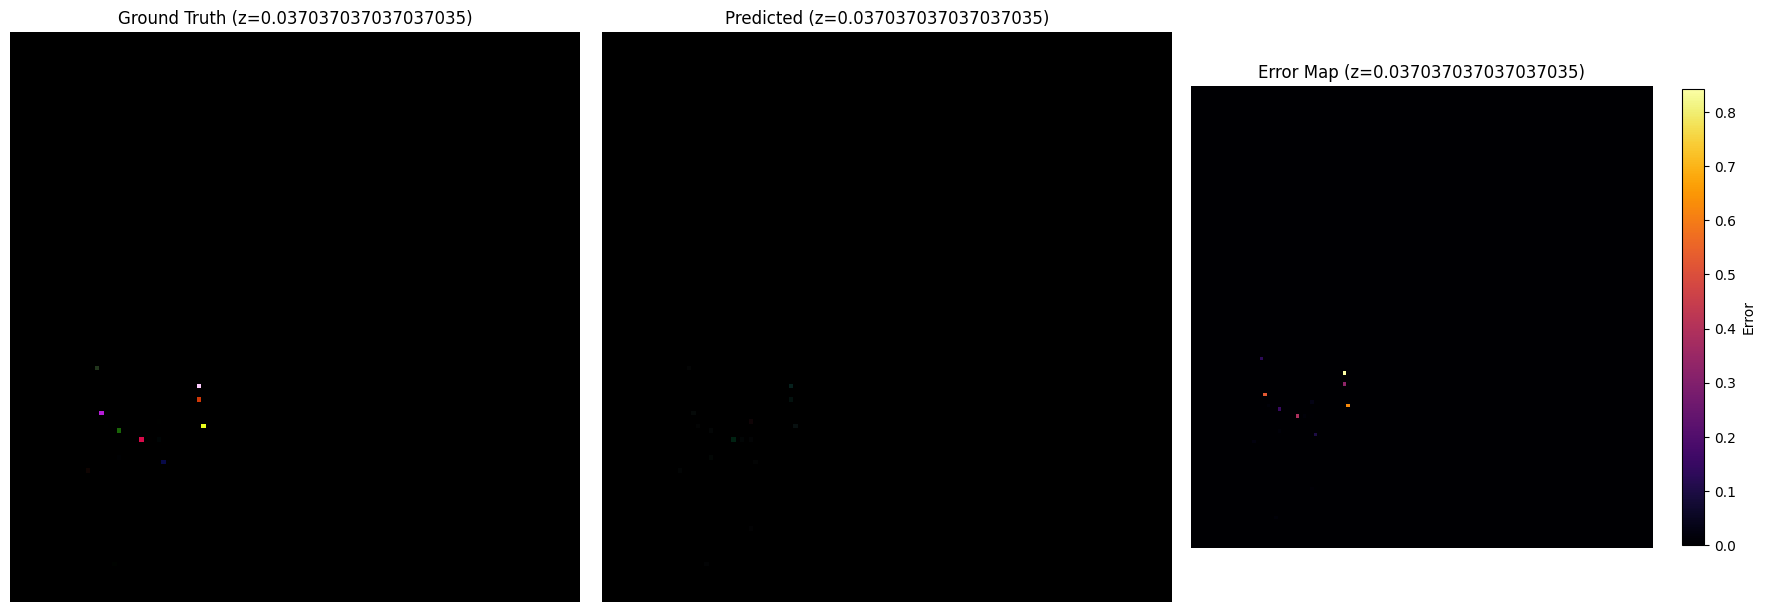

Visualizing slice for z=0.37037037037037035


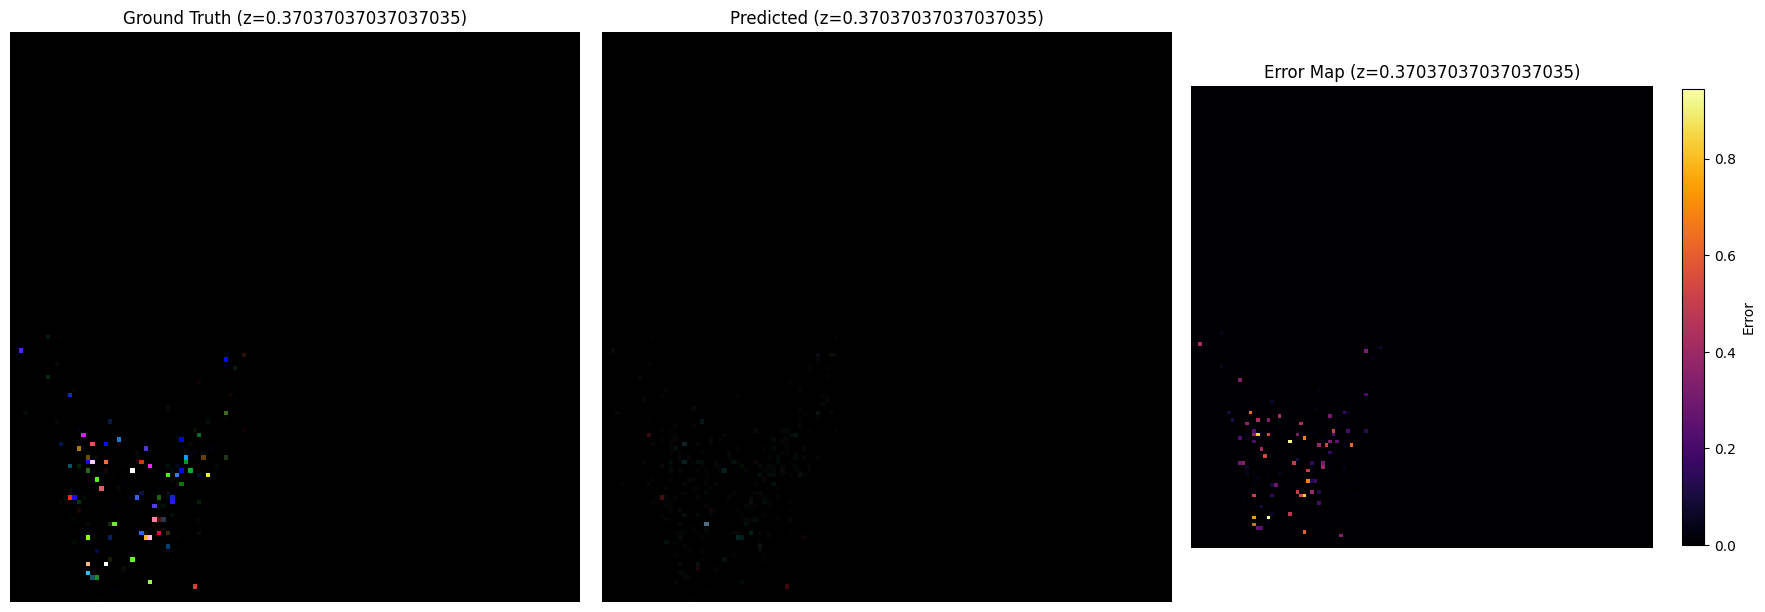

Visualizing slice for z=0.3333333333333333


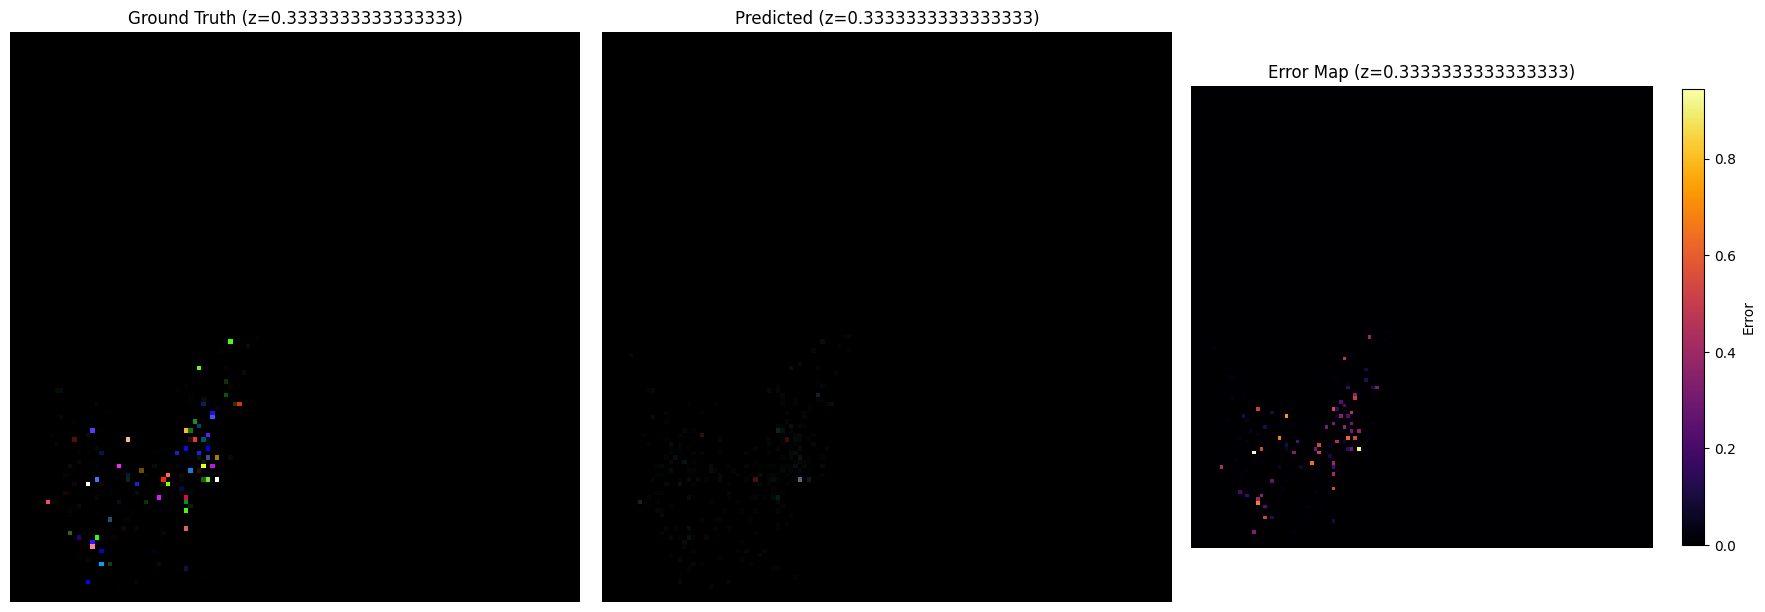

Visualizing slice for z=0.2222222222222222


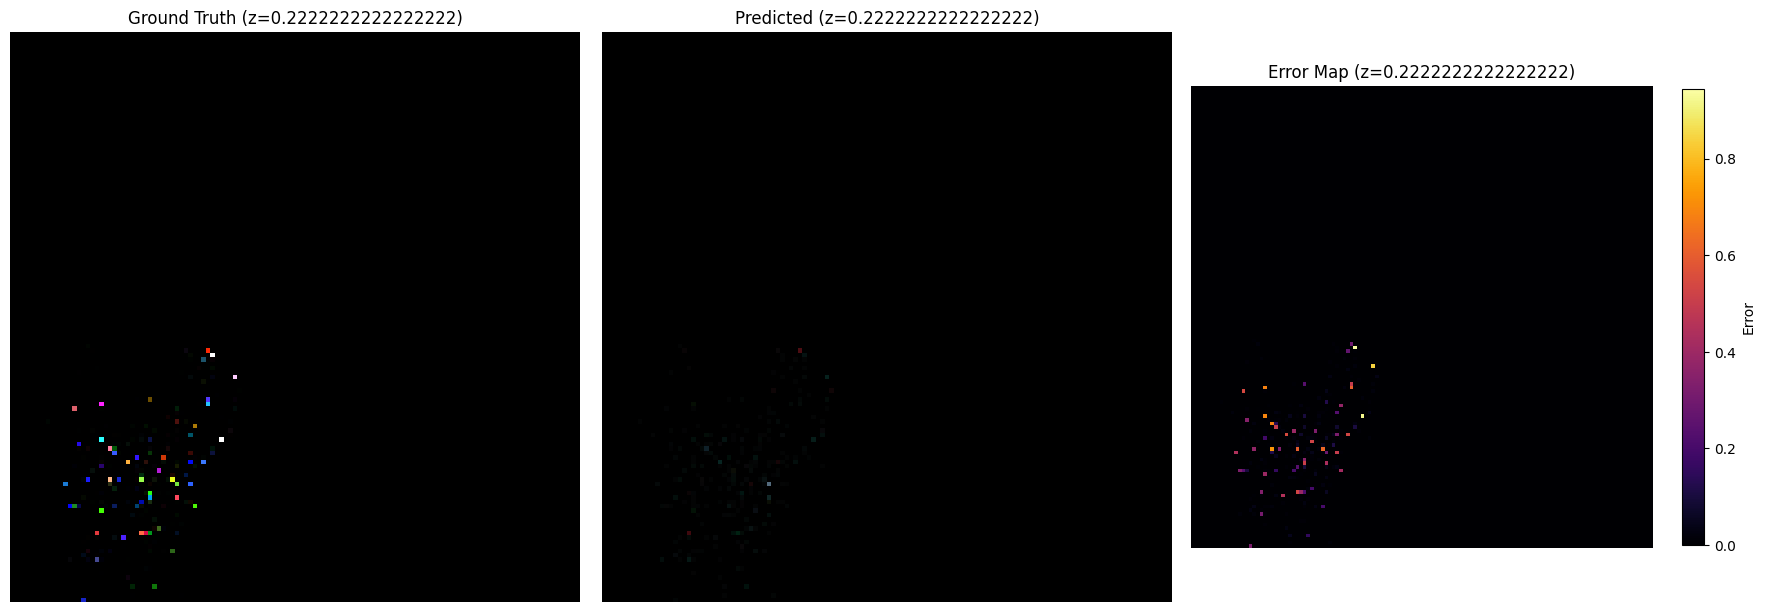

Visualizing slice for z=0.2962962962962963


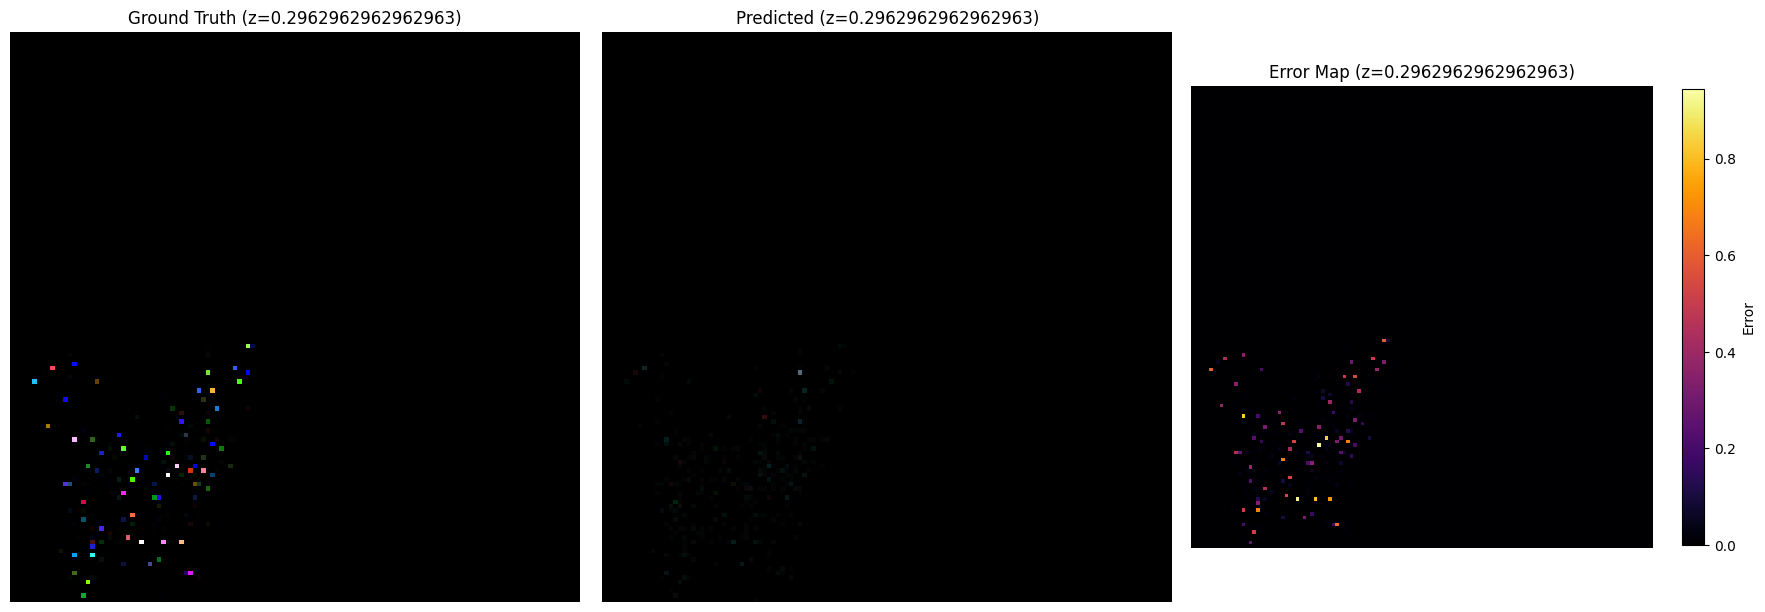

Visualizing slice for z=0.5555555555555556


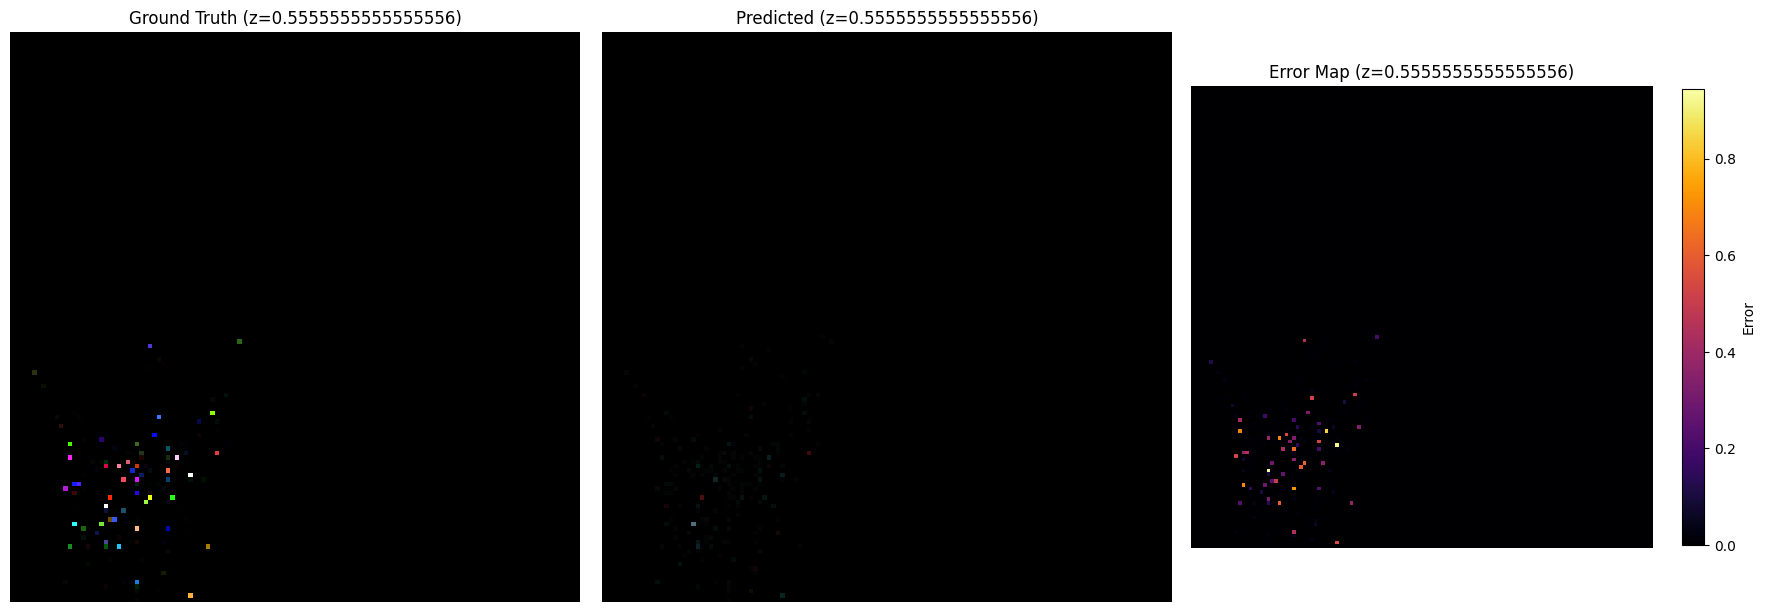

Visualizing slice for z=0.07407407407407407


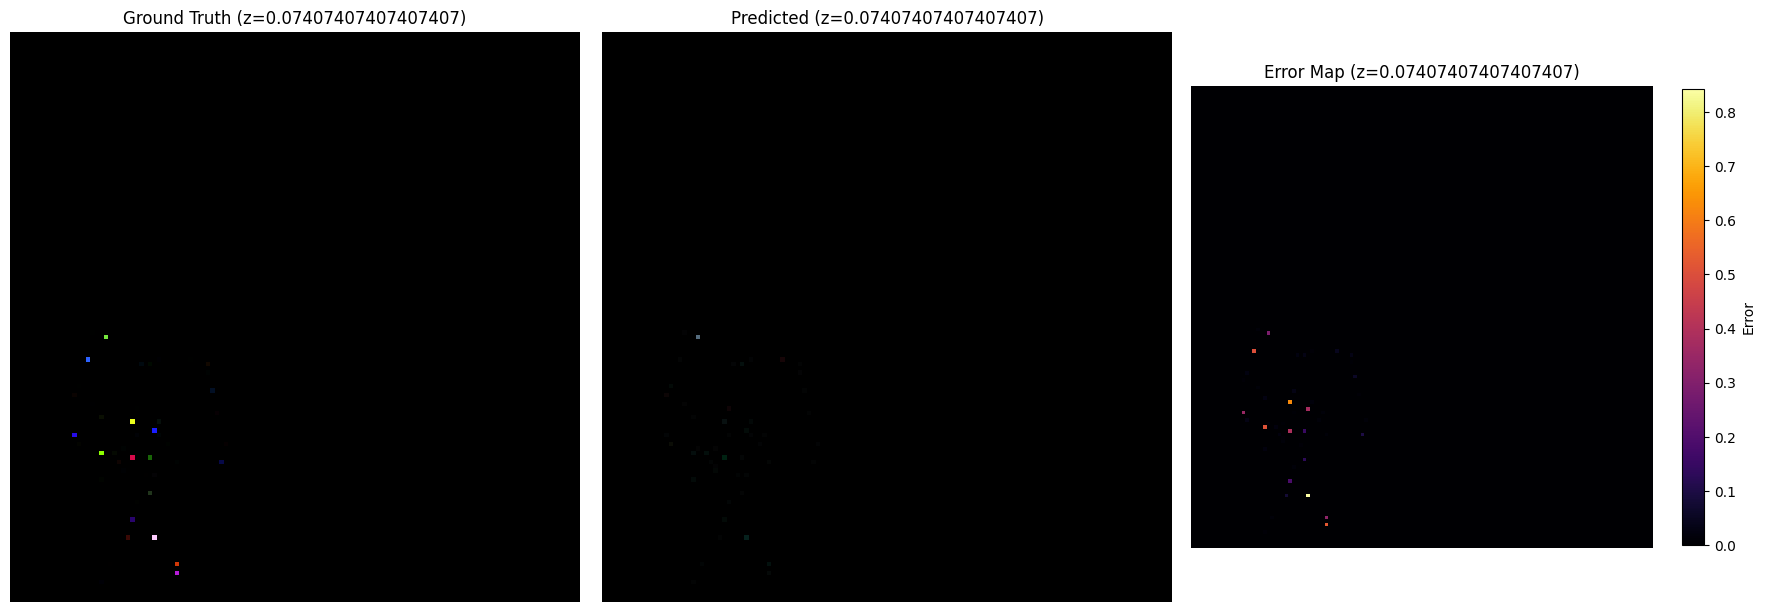

Visualizing slice for z=0.5925925925925926


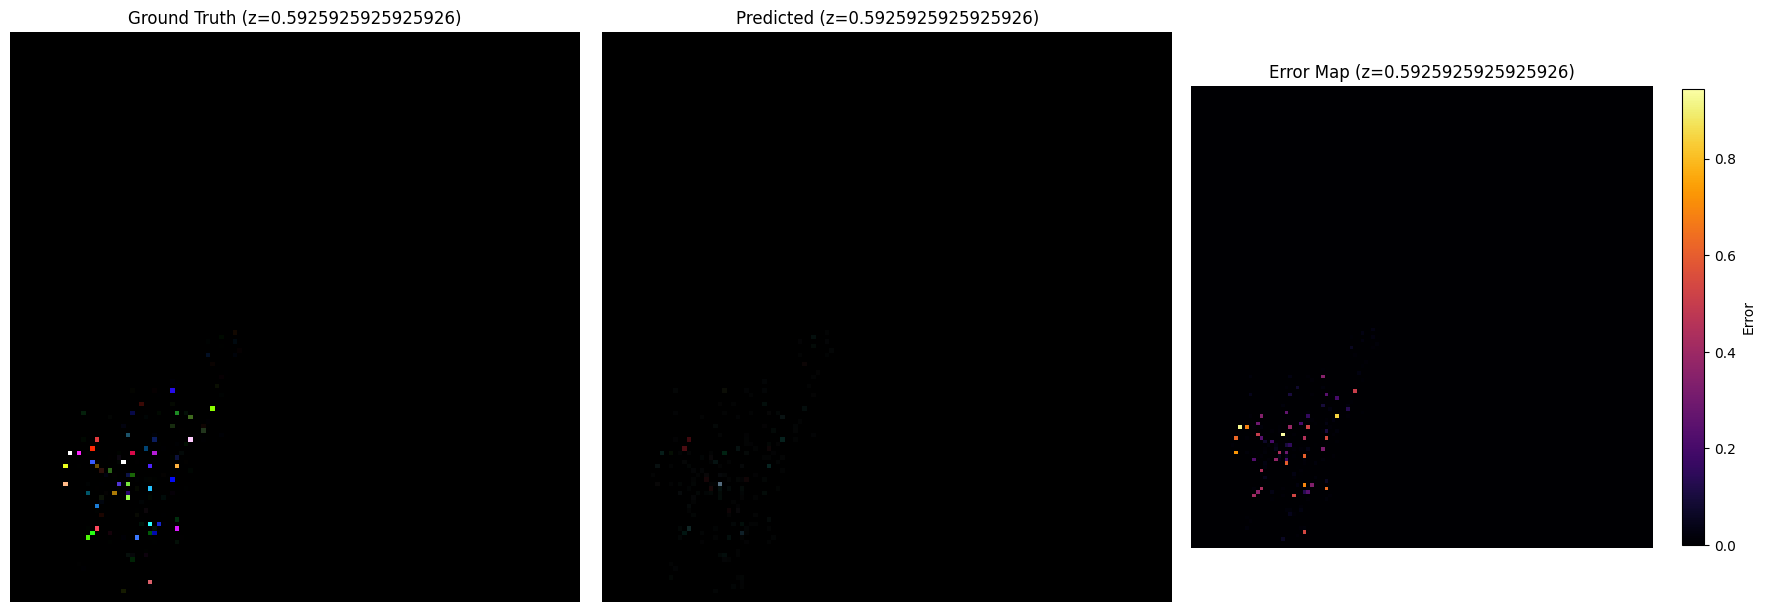

Visualizing slice for z=0.6666666666666666


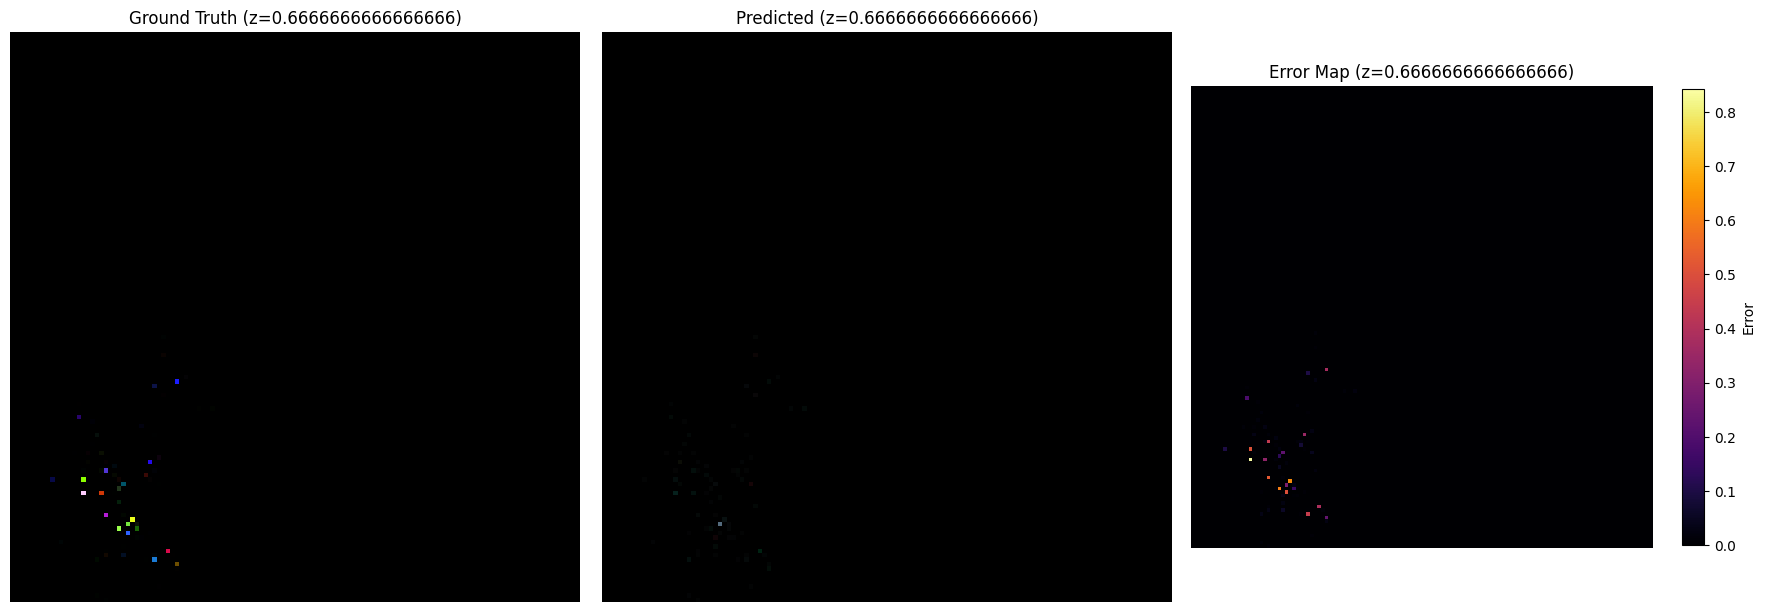

Visualizing slice for z=0.6296296296296297


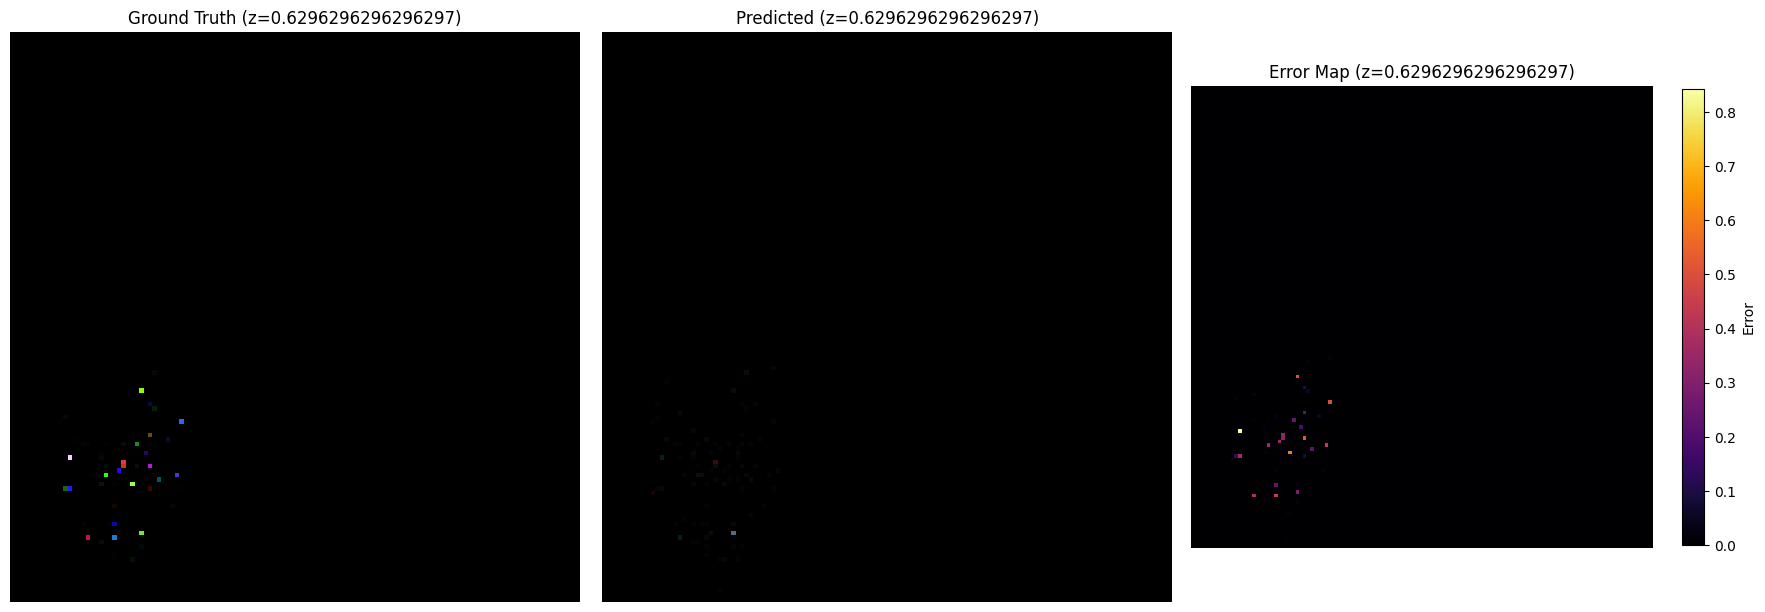

Visualizing slice for z=0.7407407407407407


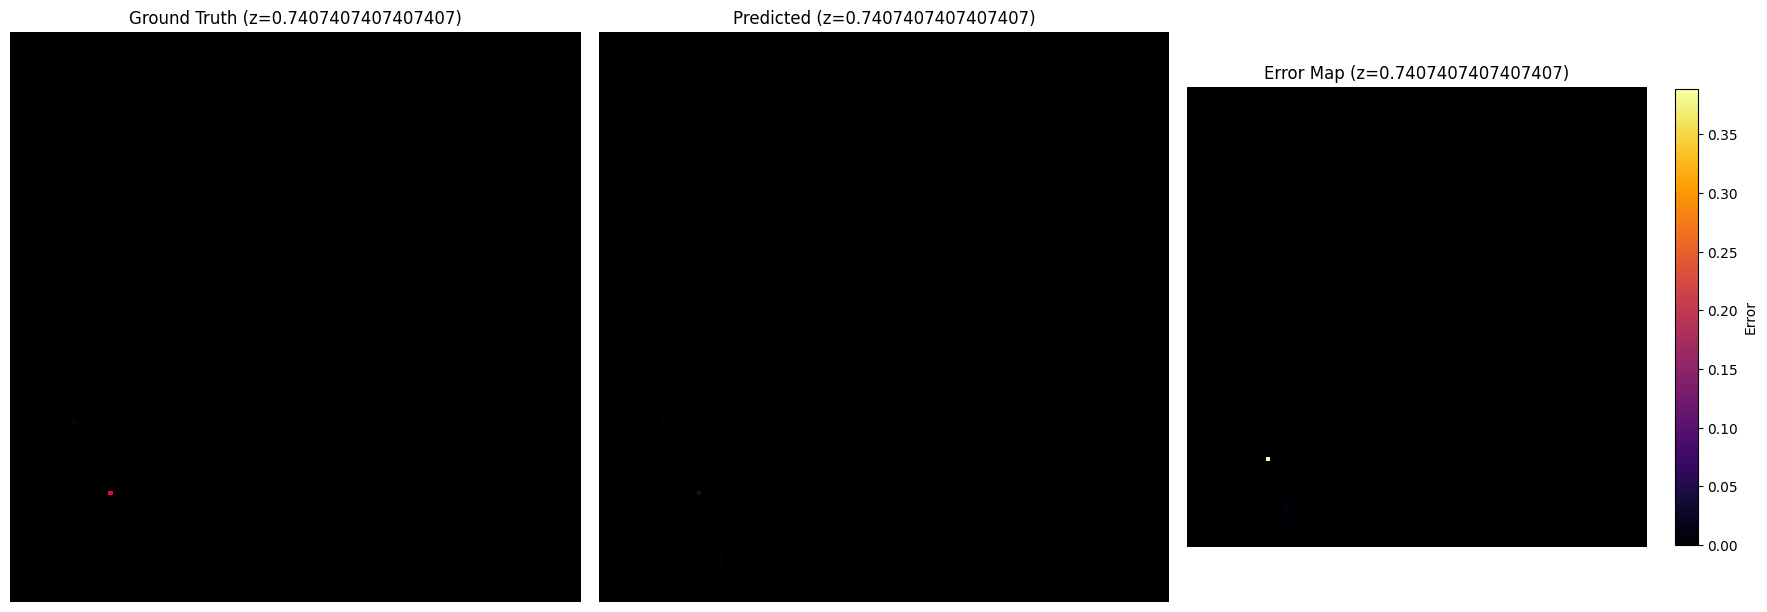

Visualizing slice for z=0.7037037037037037


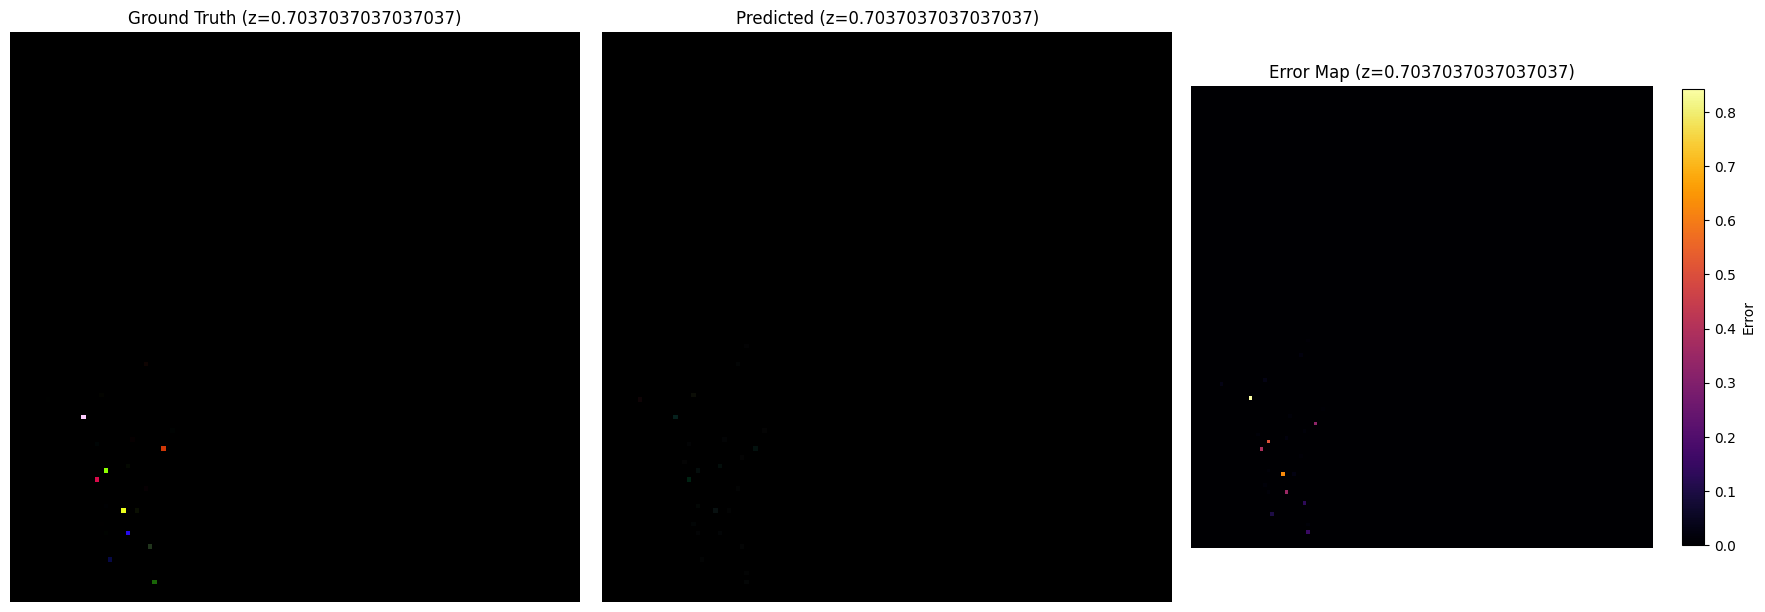

Visualizing slice for z=0.3888888888888889


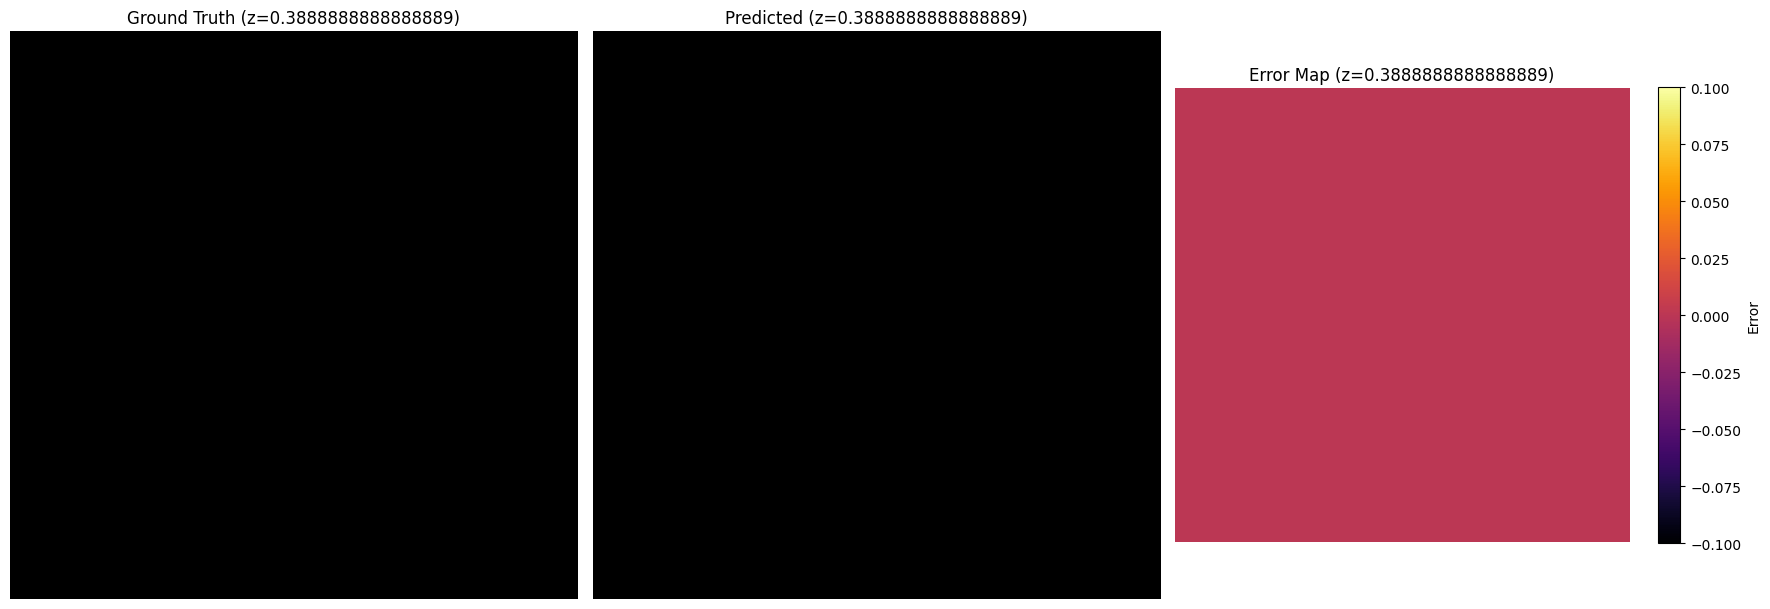

Visualizing slice for z=0.35185185185185186


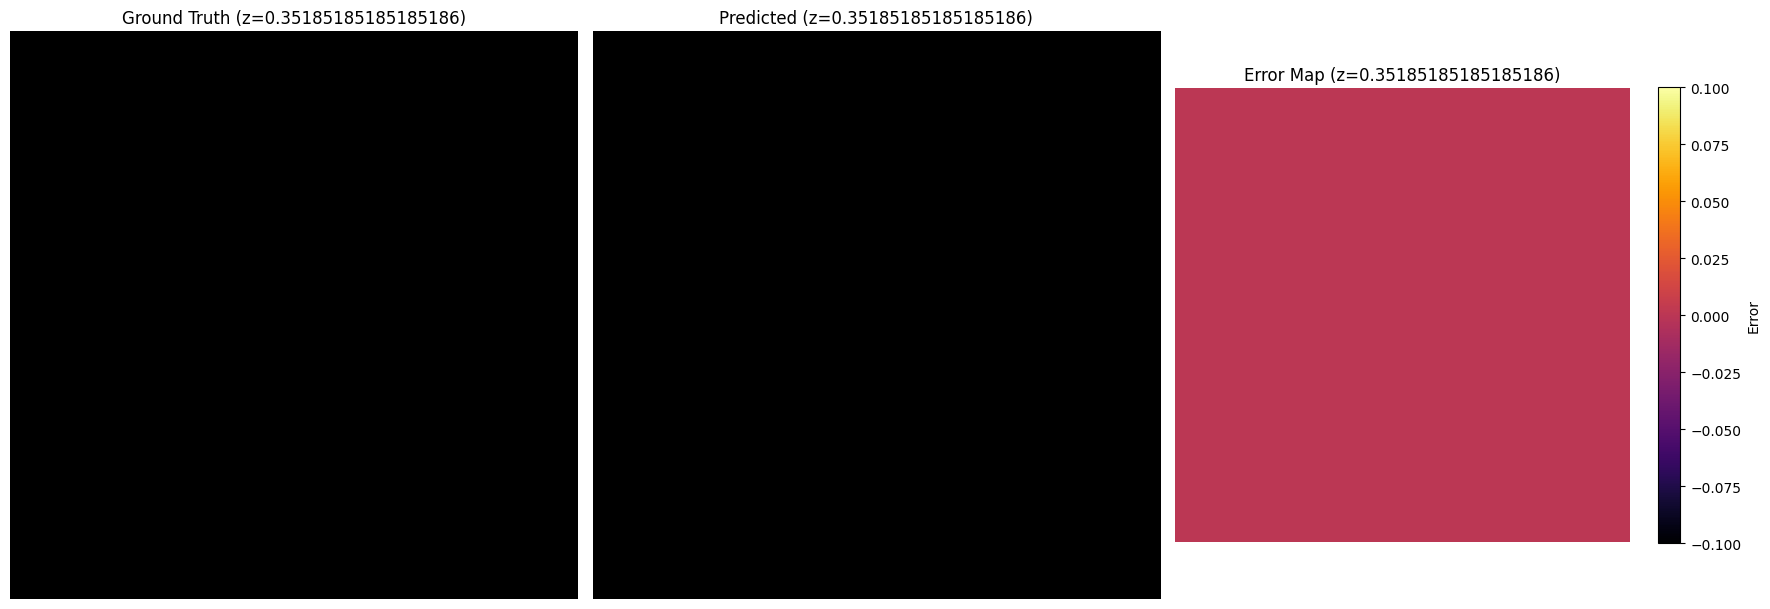

Visualizing slice for z=0.16666666666666666


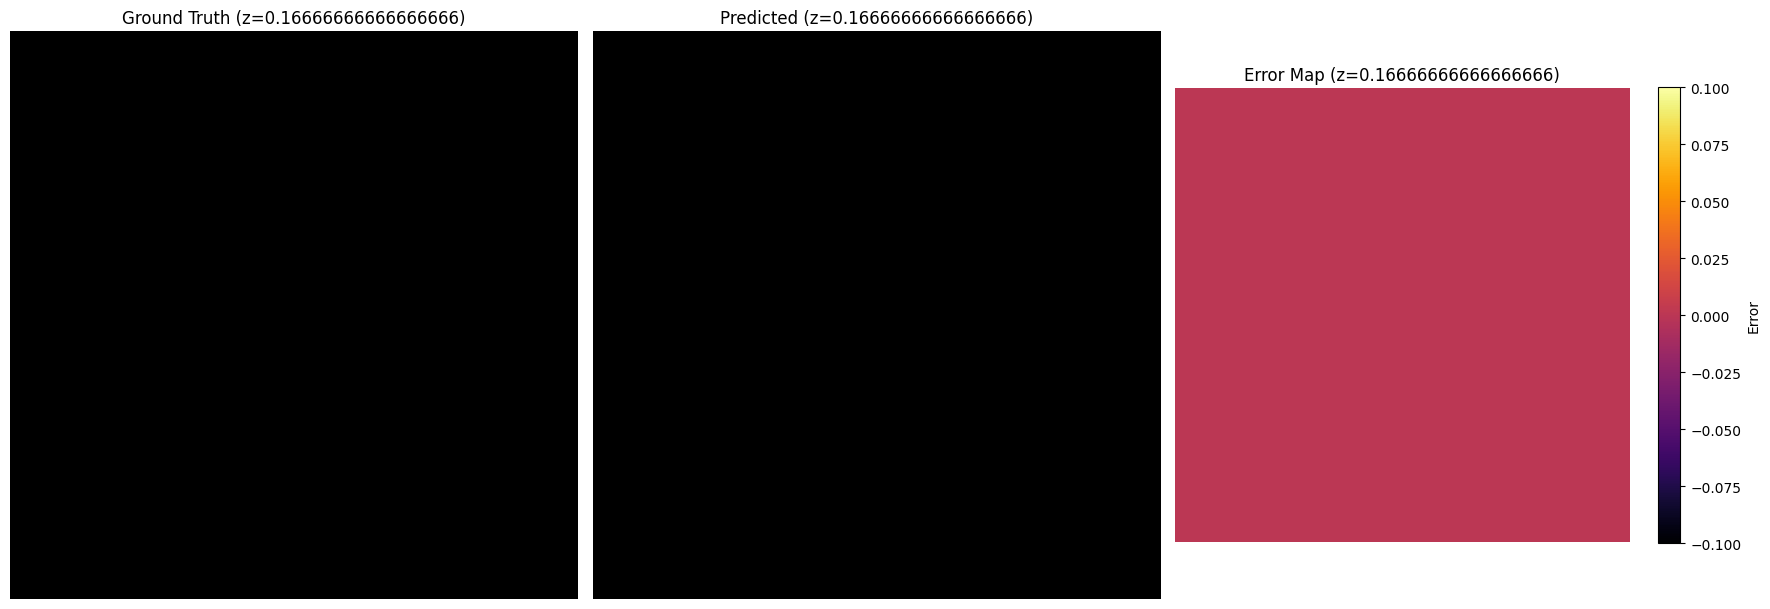

Visualizing slice for z=0.42592592592592593


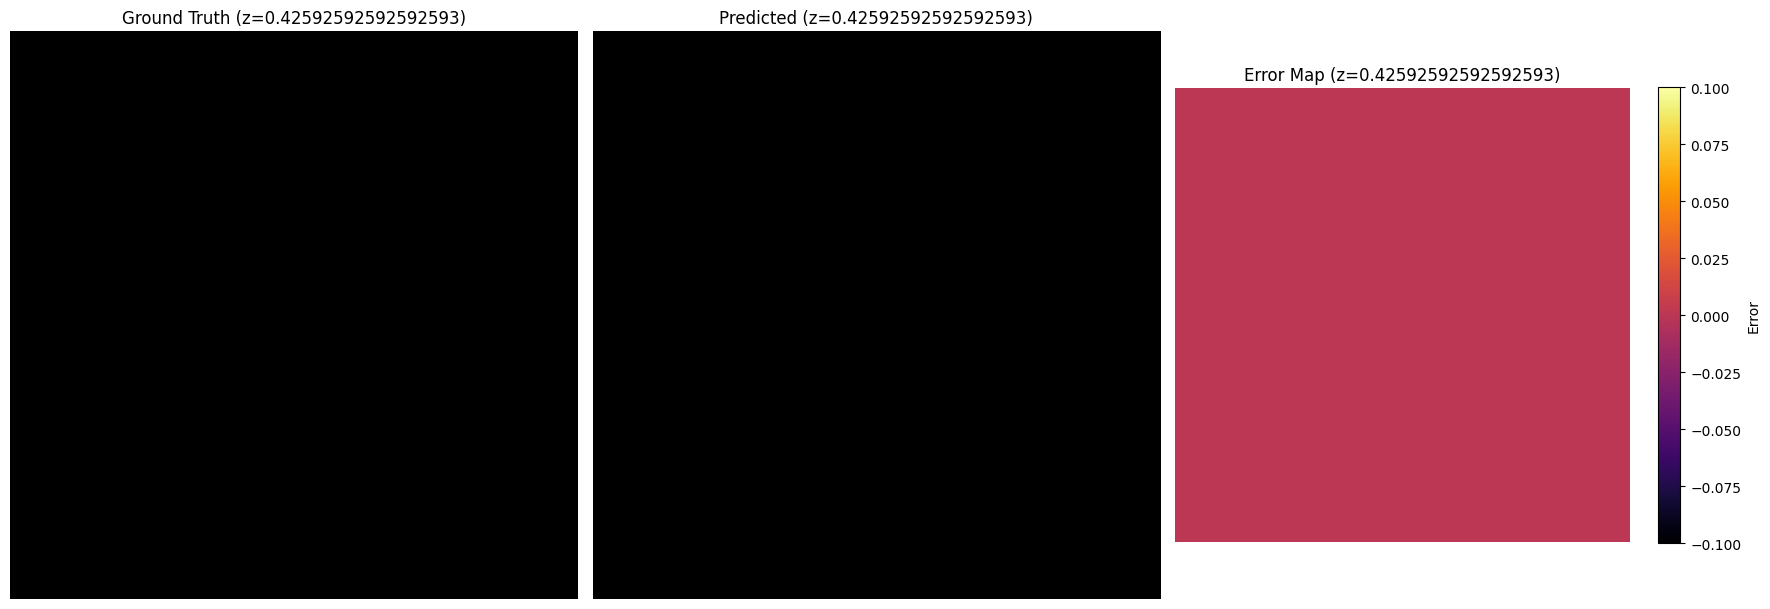

Visualizing slice for z=0.2037037037037037


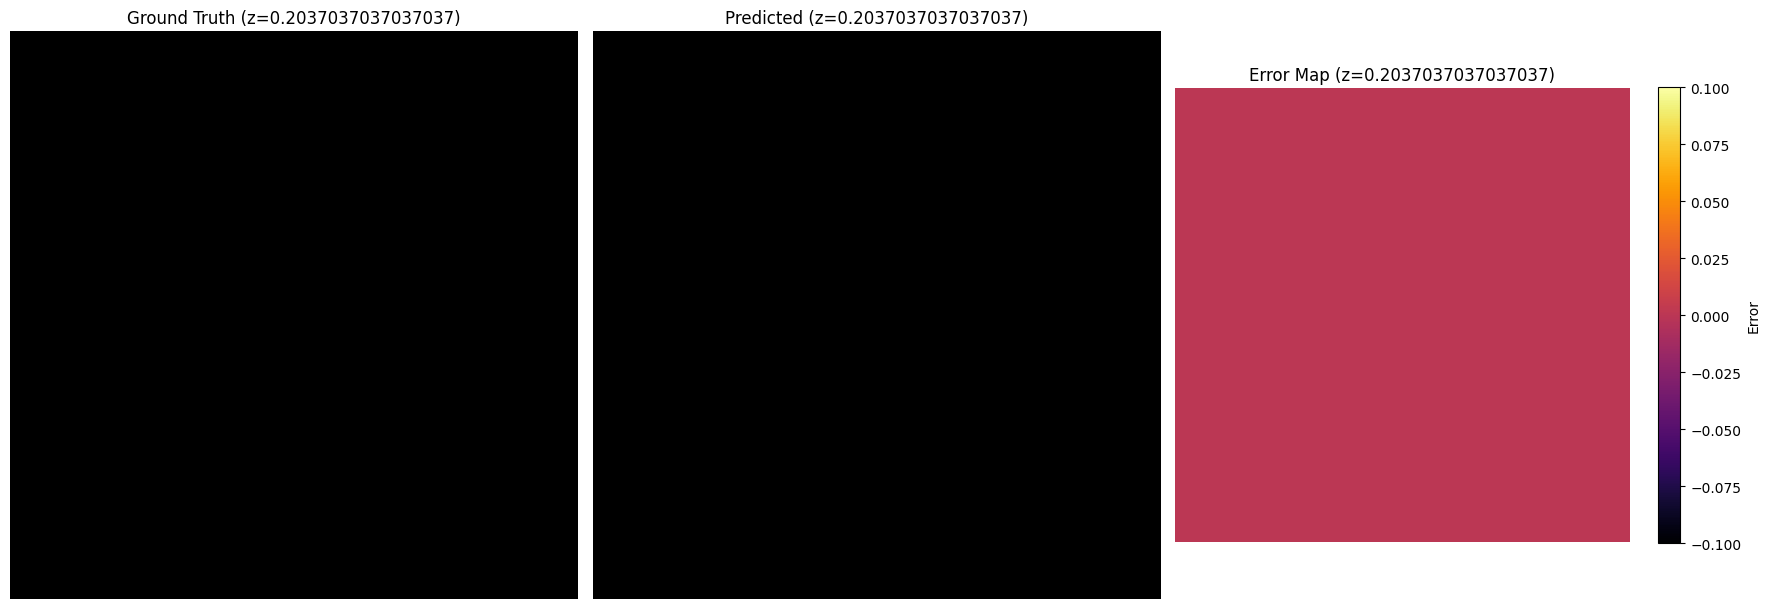

Visualizing slice for z=0.3148148148148148


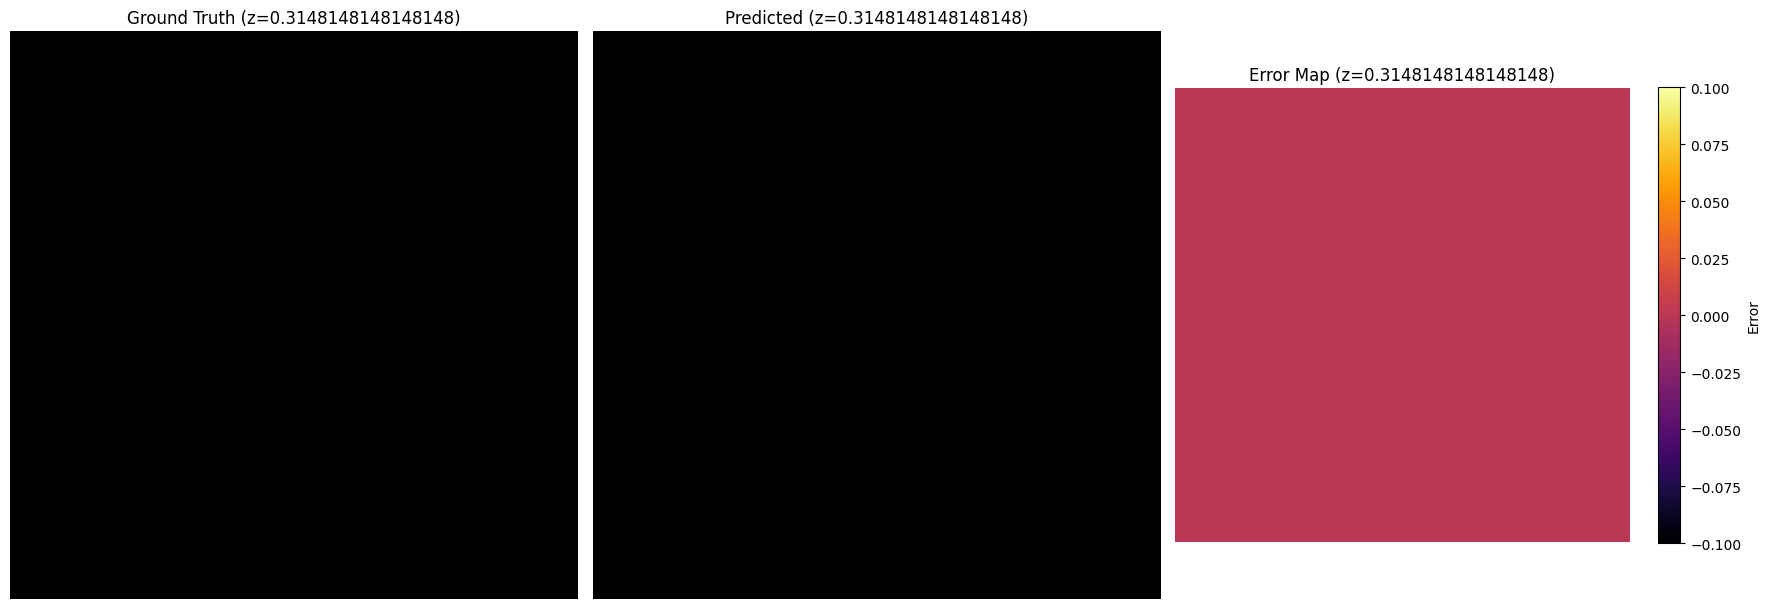

Visualizing slice for z=0.46296296296296297


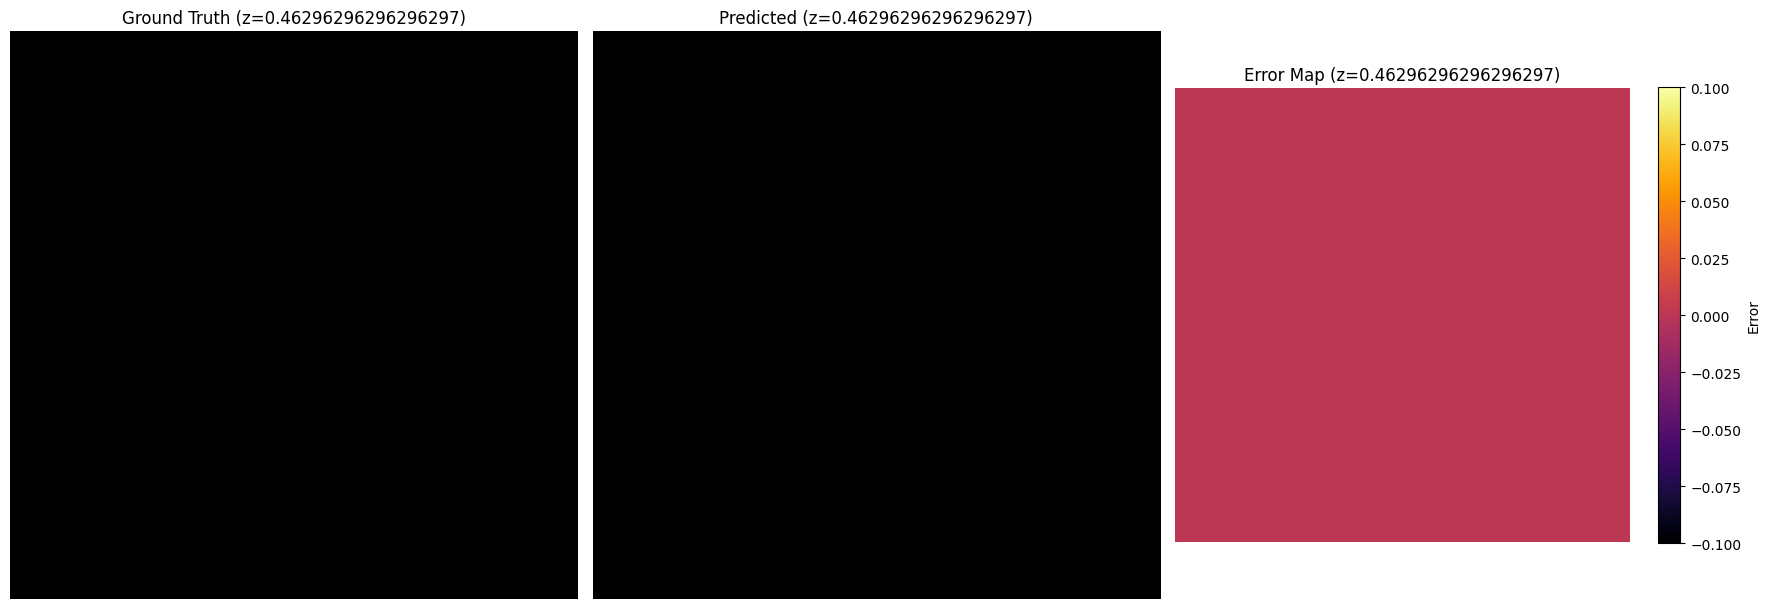

Visualizing slice for z=0.2777777777777778


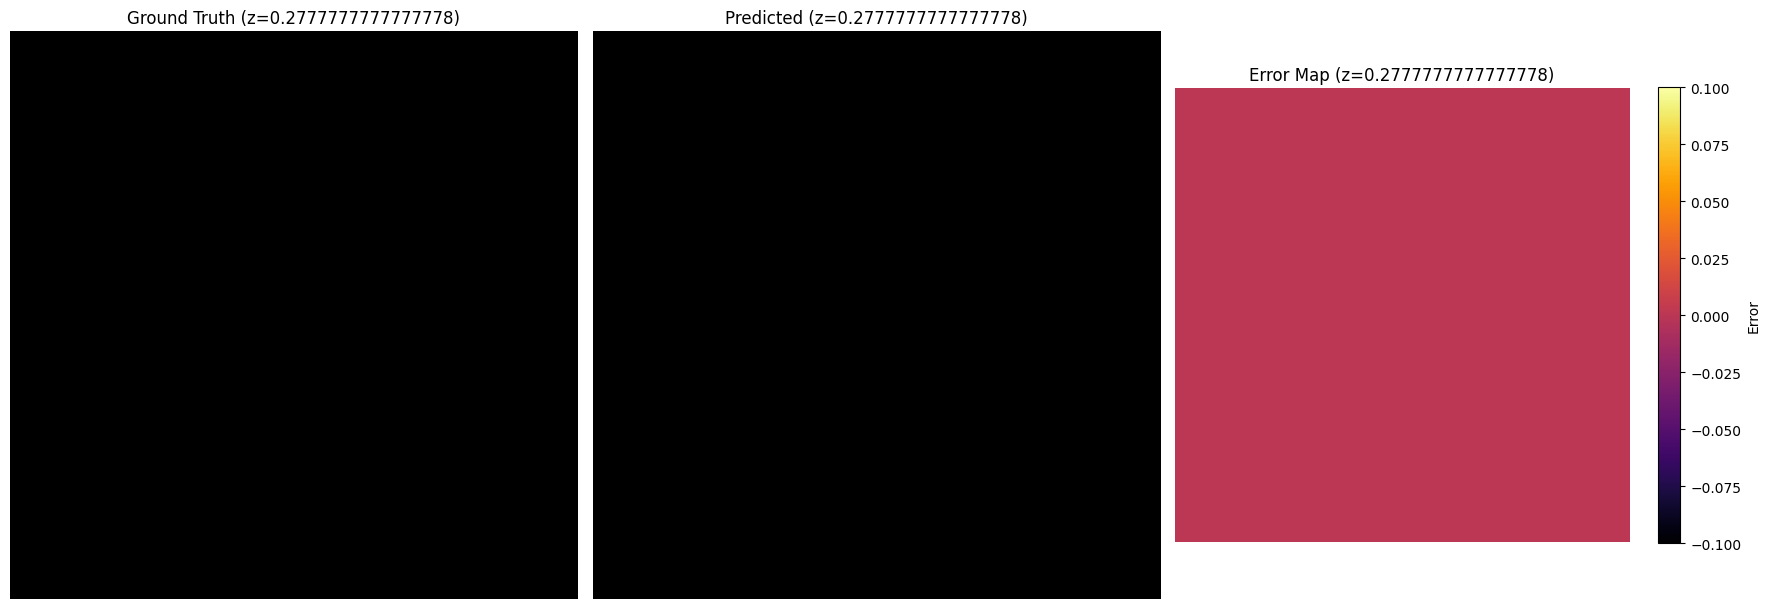

Visualizing slice for z=0.09259259259259259


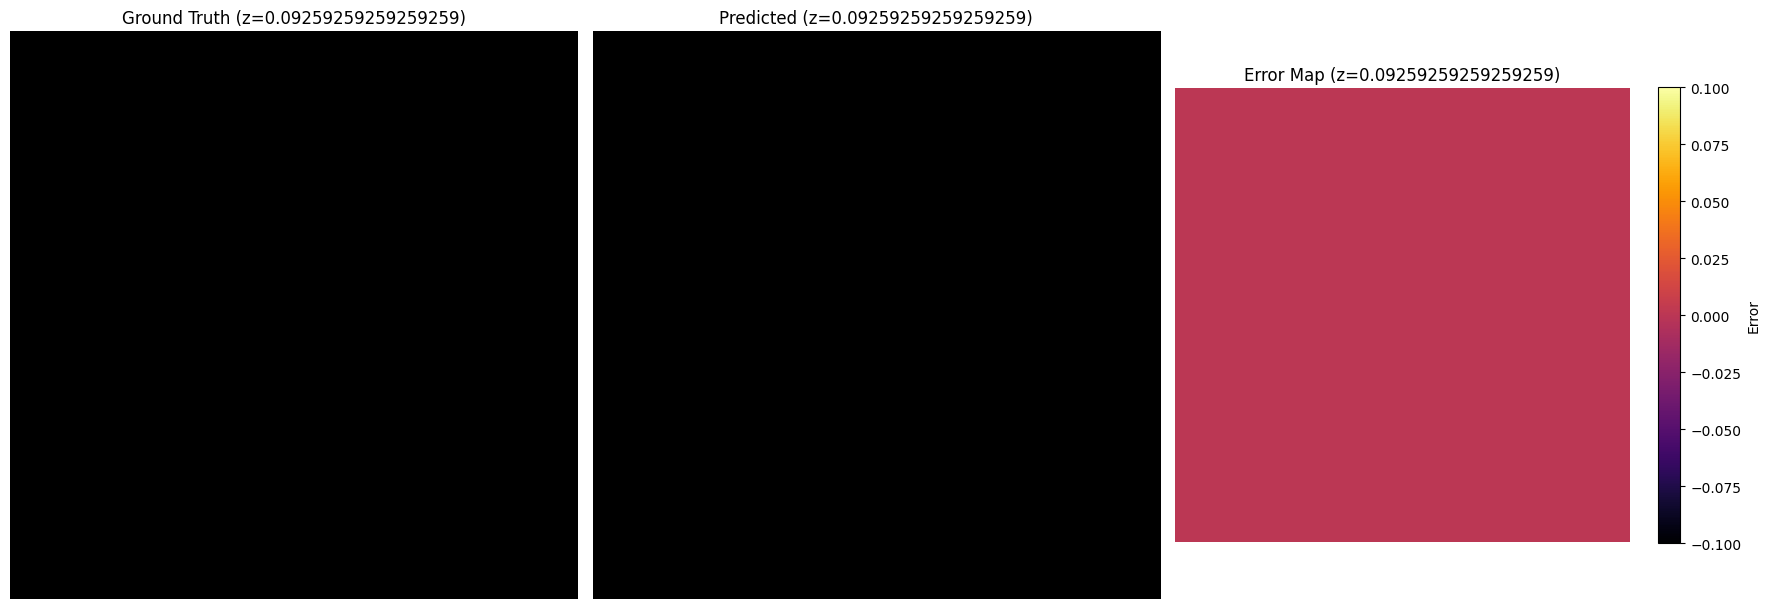

Visualizing slice for z=0.24074074074074073


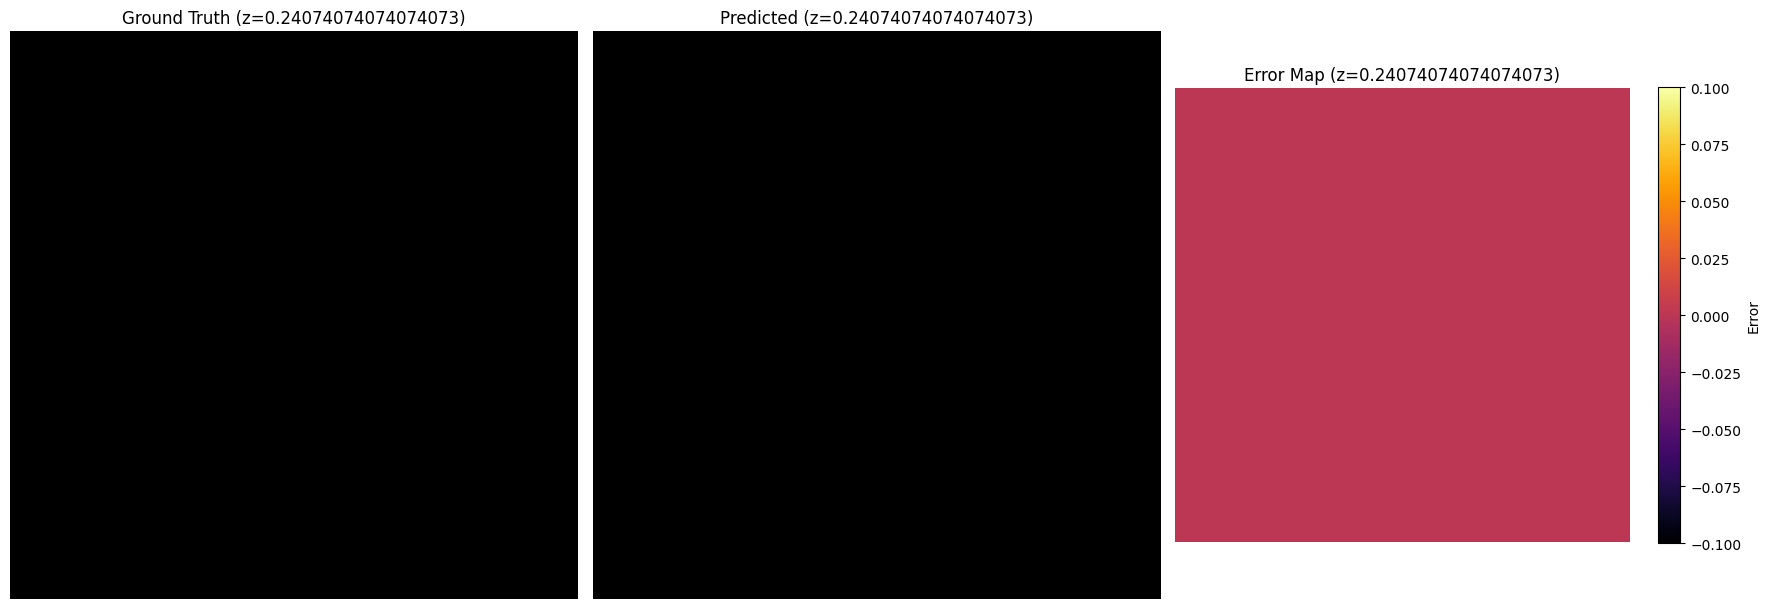

Visualizing slice for z=0.5


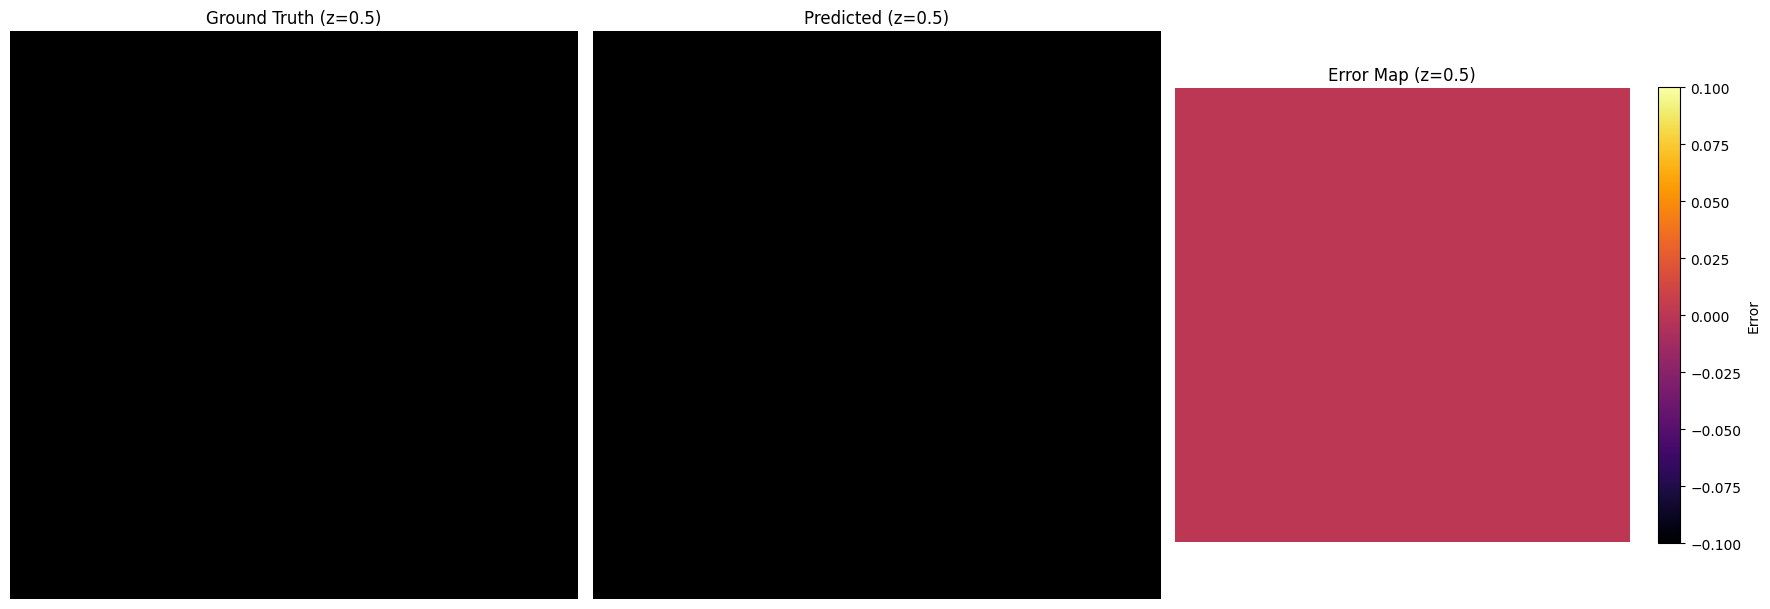

In [ ]:
def visualize_slice(z_value, data, predictions, ground_truths, grid_size=128):
    """
    Visualize a slice of data in the XY plane for a specific z value.
    
    Parameters:
    - z_value: The z-value to filter data points.
    - data: The original data DataFrame.
    - predictions: Predicted RGB values as a NumPy array of shape [N, 3].
    - ground_truths: Ground truth RGB values as a NumPy array of shape [N, 3].
    - grid_size: The size of the visualization grid (default is 128x128).
    """
    # Filter data for the specified z-value
    slice_data = data[data['zr'] == z_value]
    if slice_data.empty:
        print(f"No data available for z={z_value}")
        return
    
    # Filter indices to match predictions and ground truths
    slice_data = slice_data[slice_data.index < len(ground_truths)]
    slice_indices = slice_data.index

    # Initialize grids for ground truth and predictions
    gt_grid = np.zeros((grid_size, grid_size, 3))  # RGB for ground truth
    pred_grid = np.zeros((grid_size, grid_size, 3))  # RGB for predictions
    
    # Map xy coordinates to grid indices
    x_indices = (slice_data['xr'] * (grid_size - 1)).astype(int).values
    y_indices = (slice_data['yr'] * (grid_size - 1)).astype(int).values
    
    # Populate grids with ground truth and predictions
    for idx, (x, y) in enumerate(zip(x_indices, y_indices)):
        gt_grid[x, y] = ground_truths[idx]  # Ground truth RGB
        pred_grid[x, y] = predictions[idx]  # Predicted RGB
    
    # Calculate the error map
    error_map = np.abs(gt_grid - pred_grid).mean(axis=-1)  # Mean error per pixel
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Ground truth image
    axes[0].imshow(gt_grid, origin='lower')
    axes[0].set_title(f"Ground Truth (z={z_value})")
    axes[0].axis("off")
    
    # Predicted image
    axes[1].imshow(pred_grid, origin='lower')
    axes[1].set_title(f"Predicted (z={z_value})")
    axes[1].axis("off")
    
    # Error map
    im = axes[2].imshow(error_map, origin='lower', cmap="inferno")
    axes[2].set_title(f"Error Map (z={z_value})")
    axes[2].axis("off")
    
    # Add colorbar for the error map
    cbar = fig.colorbar(im, ax=axes[2], orientation="vertical", shrink=0.8)
    cbar.set_label("Error")
    
    plt.tight_layout()
    plt.show()

# Define the z-values you want to visualize
z_values_to_visualize = [0.1, 0.3, 0.5, 0.7, 0.9]  # Replace with your specific z-values

# Loop over each z-value and visualize the corresponding slice
for z_value in data['zr'].unique():
    print(f"Visualizing slice for z={z_value}")
    visualize_slice(z_value, data, predictions, ground_truths, grid_size=128)

